# Personalized Cancer Diagnosis

## Description
<p>A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.</p>
<p>Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers).  As not all mutations lead to cancer.</p>
<p>Due to a mutation in a gene, there is some genetic variation developed in a gene. But the question comes, from which particular mutation this genetic variation happened in a gene. Currently this interpretation of genetic mutations is being done manually which is a very time-consuming task. Based on a gene and a variation in it, a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.</p>


## Business Problem
<p>The workflow is as follows:</p>
<p>1. A molecular pathologist selects a list of genetic variations of interest that he/she want to analyze.</p>
<p>2. The molecular pathologist searches for evidence in the medical literature that somehow are relevant to the genetic variations of interest.</p>
<p>3. Finally, this molecular pathologist spends a huge amount of time analyzing the evidence related to each of the variations to classify them into any one of the 9 different classes.</p>
<p>Our goal here is to replace step 3 by a machine learning model. The molecular pathologist will still have to decide which variations are of interest, and also collect the relevant evidence for them. But the last step, which is also the most time consuming, will be fully automated by a machine learning model.</p>

## Problem Statement
<p>Classify the given genetic variations/mutations based on evidence from text-based clinical literature. In this problem, we need to find the mutation-type given the gene, variation and some text data from published research.</p>

## Source of Data
<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data</p>
<p> Data: Memorial Sloan Kettering Cancer Center (MSKCC)</p>

## Real-world/Business objectives and constraints.
* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

## Machine Learning Problem Formulation
### Data Overview
<p>- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data</p>
<p>- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. Both these data files are have a common column called ID.</p>
<p>Data file's information:</p>
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>

## Mapping the real-world problem to an ML problem

### Type of Machine Learning Problem

<p>There are nine different classes a genetic mutation can be classified into => Multi class classification problem</p>

### Performance Metric

<p>Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation</p>

<h4 style = "font-size:17px">Metric(s):</h4>

<ul> 
    <li>
        Multi class log-loss
    </li>
    <li>
        Confusion matrix 
    </li>
</ul>

## File Descriptions
<p><b>TrainingData</b> - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations), Class (1-9 the class this genetic mutation has been classified on)</p>
<p><b>TrainingText</b> - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)</p>

## Train, CV and Test Datasets
<p> Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively</p>

<h1>Exploratory Data Analysis</h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import time
import math
import re
warnings.simplefilter('ignore')
from collections import Counter, defaultdict
from scipy.sparse import hstack
from scipy.sparse import vstack
from mlxtend.classifier import StackingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<h1>Reading Data</h1>

In [3]:
data = pd.read_csv("../Data/TrainingData")

In [4]:
data.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
data.shape

(3321, 4)

In [6]:
data_text = pd.read_csv("../Data/TrainingText", sep = "\|\|", names = ["ID", "Text"])

In [7]:
data_text = data_text.drop(0, axis = 0)

In [8]:
data_text = data_text.reset_index(drop = True)

In [9]:
data_text.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [10]:
data_text.shape

(3321, 2)

In [11]:
data_text = data_text.drop(["ID"], axis = 1)

In [12]:
Final_Data = pd.concat([data, data_text], axis = 1)

In [13]:
Final_Data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [14]:
Final_Data_Label = Final_Data["Class"]

In [15]:
Final_Data = Final_Data.drop(["Class"], axis = 1)

In [16]:
Final_Data.head()

,ID,Gene,Variation,Text
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...


In [17]:
Final_Data = pd.concat([Final_Data, Final_Data_Label], axis = 1)

In [18]:
Final_Data.head()

,ID,Gene,Variation,Text,Class
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...,1
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...,2
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...,2
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...,3
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...,4


In [19]:
#checking for rows having text column as nan
for index, textinfo in Final_Data.iterrows():
    if type(textinfo["Text"]) is not str:
        print(index)

1109
1277
1407
1639
2755


In [20]:
#removing rows with text data as nan
for index, textinfo in Final_Data.iterrows():
    if type(textinfo["Text"]) is not str:
        Final_Data.drop(index, axis = 0, inplace = True)

In [21]:
Final_Data.shape

(3316, 5)

In [22]:
def pre_processing(clinicalText, indexNumber, columnName):
    if type(clinicalText) is not int:
        textString = ""
        #removing special characters
        clinicalText1 = re.sub('[^a-zA-Z0-9\n]', ' ', clinicalText)
        #remove any spaces
        clinicalText2 = re.sub('\s+', ' ', clinicalText1)
        #converting text to lowercase
        textString += clinicalText2.lower()
        Final_Data[columnName][indexNumber] = textString

In [23]:
startTime = time.clock() # this function returns wall-clock seconds elapsed since the first call to this function as float
for index, textinfo in Final_Data.iterrows():
    pre_processing(textinfo["Text"], index, "Text")
print("Total time for Preprocessing the text data = "+str(time.clock() - startTime)+"Sec")

Total time for Preprocessing the text data = 174.12587938723027Sec


In [24]:
Final_Data.head()

,ID,Gene,Variation,Text,Class
0,0,FAM58A,Truncating Mutations,cyclin dependent kinases cdks regulate a varie...,1
1,1,CBL,W802*,abstract background non small cell lung cance...,2
2,2,CBL,Q249E,abstract background non small cell lung cance...,2
3,3,CBL,N454D,recent evidence has demonstrated that acquired...,3
4,4,CBL,L399V,oncogenic mutations in the monomeric casitas b...,4


In [25]:
Final_Data_Labels = Final_Data["Class"]

In [26]:
Final_Data.shape, Final_Data_Labels.shape

((3316, 5), (3316,))

<h1>Train, cross-validation and test split</h1>
<p> Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively.</p>

In [27]:
#replacing any space with underscore
Final_Data["Gene"] = Final_Data["Gene"].str.replace("\s+", "_")
Final_Data["Variation"] = Final_Data["Variation"].str.replace("\s+", "_")

In [28]:
Final_Data.head()

,ID,Gene,Variation,Text,Class
0,0,FAM58A,Truncating_Mutations,cyclin dependent kinases cdks regulate a varie...,1
1,1,CBL,W802*,abstract background non small cell lung cance...,2
2,2,CBL,Q249E,abstract background non small cell lung cance...,2
3,3,CBL,N454D,recent evidence has demonstrated that acquired...,3
4,4,CBL,L399V,oncogenic mutations in the monomeric casitas b...,4


In [29]:
X_Train, TestData, Y_Train, TestLabels = train_test_split(Final_Data, Final_Data_Labels, stratify=Final_Data_Labels, test_size=0.2)
TrainData, CV_Data, TrainDataLabels, CV_Data_Labels = train_test_split(X_Train, Y_Train, stratify=Y_Train, test_size=0.2)

# This stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the 
# proportion of values provided to parameter stratify.
# For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, 
# stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.

In [30]:
X_Train.shape, TestData.shape, Y_Train.shape, TestLabels.shape

((2652, 5), (664, 5), (2652,), (664,))

In [31]:
print('Number of data points in train data:', TrainData.shape[0])
print('Number of data points in test data:', TestData.shape[0])
print('Number of data points in cross validation data:', CV_Data.shape[0])

Number of data points in train data: 2121
Number of data points in test data: 664
Number of data points in cross validation data: 531


<h1>Distribution of Class labels in Train, CV and Test data</h1>

In [32]:
TrainData_distribution = TrainData["Class"].value_counts().sort_index()
CVData_distribution = CV_Data["Class"].value_counts().sort_index()
TestData_distribution = TestData["Class"].value_counts().sort_index()

In [33]:
TrainData_distribution_sorted = sorted(TrainData_distribution.items(), key = lambda d: d[1], reverse = True)
CVData_distribution_sorted = sorted(CVData_distribution.items(), key = lambda d: d[1], reverse = True)
TestData_distribution_sorted = sorted(TestData_distribution.items(), key = lambda d: d[1], reverse = True)

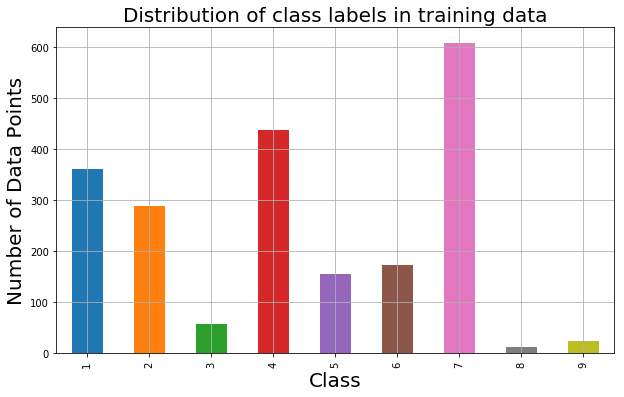

Number of training data points in class 7 = 609(28.7129%)
Number of training data points in class 4 = 439(20.6978%)
Number of training data points in class 1 = 362(17.0674%)
Number of training data points in class 2 = 289(13.6256%)
Number of training data points in class 6 = 174(8.2037%)
Number of training data points in class 5 = 155(7.3079%)
Number of training data points in class 3 = 57(2.6874%)
Number of training data points in class 9 = 24(1.1315%)
Number of training data points in class 8 = 12(0.5658%)
--------------------------------------------------------------------------------


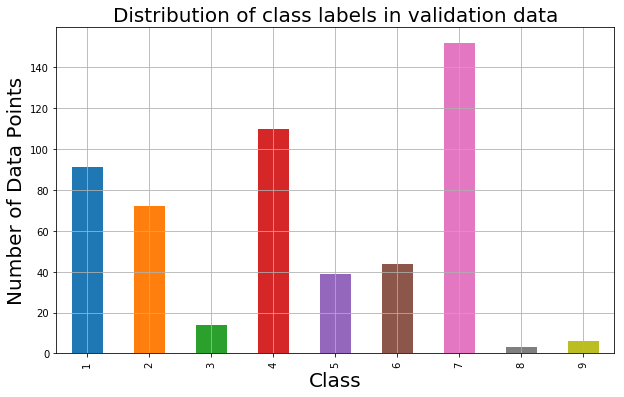

Number of CV data points in class 7 = 152(28.6252%)
Number of CV data points in class 4 = 110(20.7156%)
Number of CV data points in class 1 = 91(17.1375%)
Number of CV data points in class 2 = 72(13.5593%)
Number of CV data points in class 6 = 44(8.2863%)
Number of CV data points in class 5 = 39(7.3446%)
Number of CV data points in class 3 = 14(2.6365%)
Number of CV data points in class 9 = 6(1.1299%)
Number of CV data points in class 8 = 3(0.565%)
--------------------------------------------------------------------------------


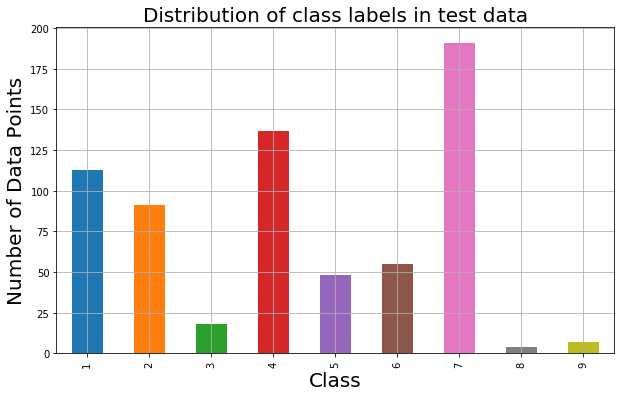

Number of test data points in class 7 = 191(28.7651%)
Number of test data points in class 4 = 137(20.6325%)
Number of test data points in class 1 = 113(17.0181%)
Number of test data points in class 2 = 91(13.7048%)
Number of test data points in class 6 = 55(8.2831%)
Number of test data points in class 5 = 48(7.2289%)
Number of test data points in class 3 = 18(2.7108%)
Number of test data points in class 9 = 7(1.0542%)
Number of test data points in class 8 = 4(0.6024%)


In [34]:
plt.figure(figsize = (10, 6))
TrainData_distribution.plot(kind = "bar")
plt.grid()
plt.title("Distribution of class labels in training data", fontsize = 20)
plt.xlabel("Class", fontsize = 20)
plt.ylabel("Number of Data Points", fontsize = 20)
plt.show()

for i in TrainData_distribution_sorted:
    print("Number of training data points in class "+str(i[0])+" = "+str(i[1])+ "("+str(np.round(((i[1]/TrainData.shape[0])*100), 4))+"%)")

print("-"*80)

plt.figure(figsize = (10, 6))
CVData_distribution.plot(kind = "bar")
plt.grid()
plt.title("Distribution of class labels in validation data", fontsize = 20)
plt.xlabel("Class", fontsize = 20)
plt.ylabel("Number of Data Points", fontsize = 20)
plt.show()

for i in CVData_distribution_sorted:
    print("Number of CV data points in class "+str(i[0])+" = "+str(i[1])+ "("+str(np.round(((i[1]/CV_Data.shape[0])*100), 4))+"%)")

print("-"*80)

plt.figure(figsize = (10, 6))
TestData_distribution.plot(kind = "bar")
plt.grid()
plt.title("Distribution of class labels in test data", fontsize = 20)
plt.xlabel("Class", fontsize = 20)
plt.ylabel("Number of Data Points", fontsize = 20)
plt.show()

for i in TestData_distribution_sorted:
    print("Number of test data points in class "+str(i[0])+" = "+str(i[1])+ "("+str(np.round(((i[1]/TestData.shape[0])*100), 4))+"%)")


<h1>Prediction using a 'Random' Model</h1>
<p>In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1.</p>

In [35]:
def print_confusionMatrix(Y_TestLabels, PredictedLabels):
    confusionMatx = confusion_matrix(Y_TestLabels, PredictedLabels)
    
    precision = confusionMatx/confusionMatx.sum(axis = 0)
    
    recall = (confusionMatx.T/confusionMatx.sum(axis = 1)).T
    
    # confusionMatx = [[1, 2],
    #                  [3, 4]]
    # confusionMatx.T = [[1, 3],
    #                   [2, 4]]
    # confusionMatx.sum(axis = 1)  axis=0 corresponds to columns and axis=1 corresponds to rows in two diamensional array
    # confusionMatx.sum(axix =1) = [[3, 7]]
    # (confusionMatx.T)/(confusionMatx.sum(axis=1)) = [[1/3, 3/7]
    #                                                  [2/3, 4/7]]

    # (confusionMatx.T)/(confusionMatx.sum(axis=1)).T = [[1/3, 2/3]
    #                                                    [3/7, 4/7]]
    # sum of row elements = 1
    
    labels = [i for i in range(1, 10)]
    
    plt.figure(figsize=(20,7))
    sns.heatmap(confusionMatx, cmap = "Reds", annot = True, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.show()
    
    print("-"*125)
    
    plt.figure(figsize=(20,7))
    sns.heatmap(precision, cmap = "Reds", annot = True, fmt = ".4f", xticklabels=labels, yticklabels=labels)
    plt.title("Precision Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.show()
    
    print("-"*125)
    
    plt.figure(figsize=(20,7))
    sns.heatmap(recall, cmap = "Reds", annot = True, fmt = ".3f", xticklabels=labels, yticklabels=labels)
    plt.title("Recall Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.show()

Log loss on Cross Validation Data using Random Model 2.4908584438935715
Log loss on Test Data using Random Model 2.5051221373926853


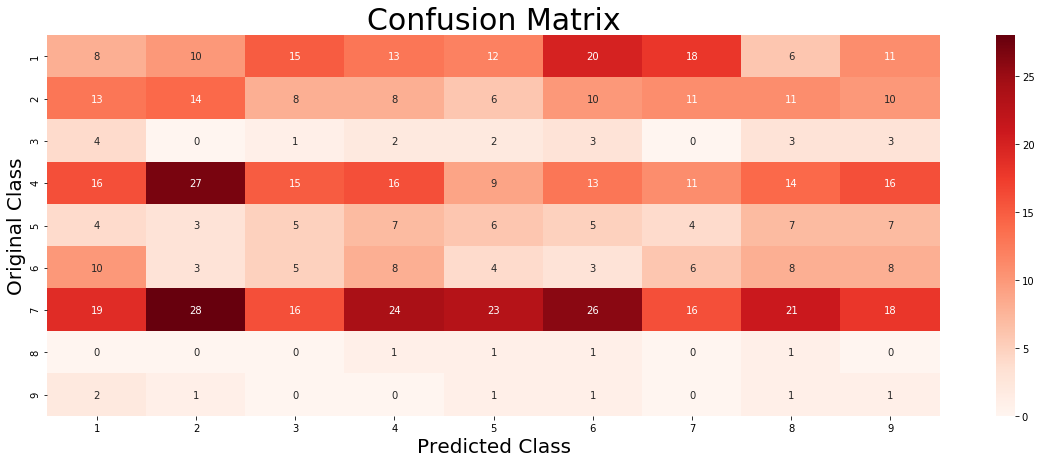

-----------------------------------------------------------------------------------------------------------------------------


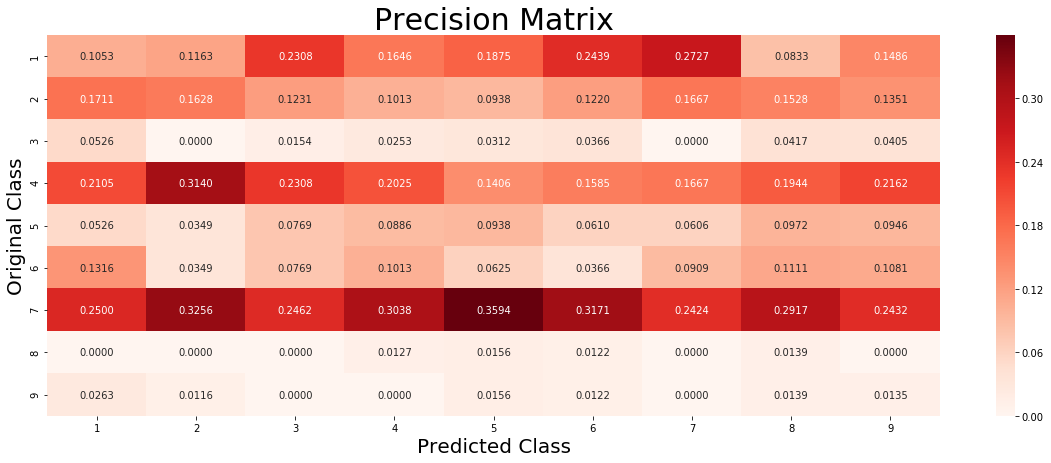

-----------------------------------------------------------------------------------------------------------------------------


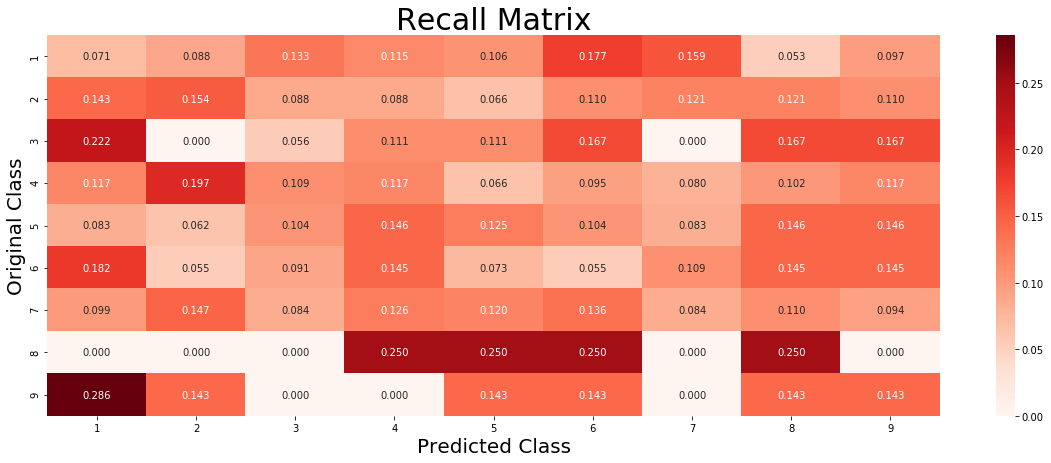

In [36]:
testDataLength = TestData.shape[0]
CVDataLength = CV_Data.shape[0]

CV_predicted_probs = np.zeros((CVDataLength,9))
for i in range(CVDataLength):
    rand_probs_CV = np.random.rand(1,9)  #it will return an array of random numbers between 1 and 0 of size 1*9
    CV_predicted_probs[i] = (rand_probs_CV/sum(sum(rand_probs_CV)))[0]  #it will generate random probabilities of each point in CV data such that theor sum = 1
print("Log loss on Cross Validation Data using Random Model "+str(log_loss(CV_Data_Labels,CV_predicted_probs)))

test_predicted_probs = np.zeros((testDataLength,9))
for i in range(testDataLength):
    rand_probs_test = np.random.rand(1,9)  #it will return an array of random numbers between 1 and 0 of size 1*9
    test_predicted_probs[i] = (rand_probs_test/sum(sum(rand_probs_test)))[0]  #it will generate random probabilities of each point in CV data such that theor sum = 1
print("Log loss on Test Data using Random Model "+str(log_loss(TestLabels, test_predicted_probs)))

pred_test_labels = np.argmax(test_predicted_probs, axis = 1)  #here, axis 1 means row wise
print_confusionMatrix(TestLabels, pred_test_labels+1)  #here pred_test_labels+1 plus 1 because argmax counts from 0 but our class labels are from 1 to 9

In [37]:
def response_coded_featureDict(alpha, feature, df):
    
    value_count = TrainData[feature].value_counts()
    rc_values = dict()
    
    for i, denominator in value_count.items():
        vec = []
        for k in range(1, 10):
            cls_cnt = TrainData.loc[(TrainData["Class"]==k) & (TrainData[feature]==i)]
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+(90*alpha))
# here, adding 10*alpha in numerator and 90*alpha in denominator is nothing but laplace smoothing which we did in Naive Bayes 
            vec.append((cls_cnt.shape[0] + 10*alpha)/denominator + (90*alpha))    
        rc_values[i] = vec
    return rc_values


def response_coded_values(alpha, feature, df):
    get_rc_values = response_coded_featureDict(alpha, feature, df)
    get_value_count = TrainData[feature].value_counts()
    get_feat_values = []
    for index, row in df.iterrows():
        if row[feature] in dict(get_value_count).keys():
            get_feat_values.append(get_rc_values[row[feature]])
        else:
            get_feat_values.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return get_feat_values

When we calculate the probability of a feature belongs to any particular class, we apply laplace smoothing
<li>(numerator + alpha) / (denominator + (9*alpha)) </li>

<h1>Univariate Analysis on Gene Feature</h1>

<p> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p><b>Ans.</b> Gene is a categorical variable </p>
<p> <b>Q2.</b> How many categories are there and how they are distributed?</p>

In [38]:
unique_genes = TrainData["Gene"].value_counts()
print("Number of Unique genes = "+str(unique_genes.shape[0]))
print(unique_genes.head(10))

Number of Unique genes = 231
BRCA1     176
TP53      111
EGFR       81
PTEN       79
BRCA2      77
BRAF       58
KIT        57
ERBB2      46
ALK        42
PDGFRA     42
Name: Gene, dtype: int64


In [39]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows:")

Ans: There are 231 different categories of genes in the train data, and they are distibuted as follows:


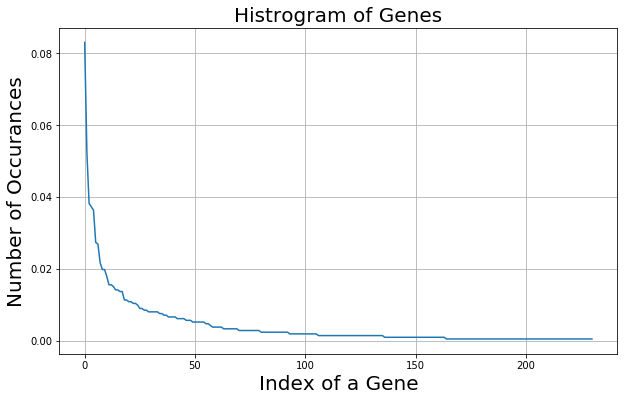

In [40]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.figure(figsize = (10, 6))
plt.plot(h)
plt.title("Histrogram of Genes", fontsize = 20)
plt.xlabel('Index of a Gene', fontsize = 20)
plt.ylabel('Number of Occurances', fontsize = 20)
plt.grid()
plt.show()

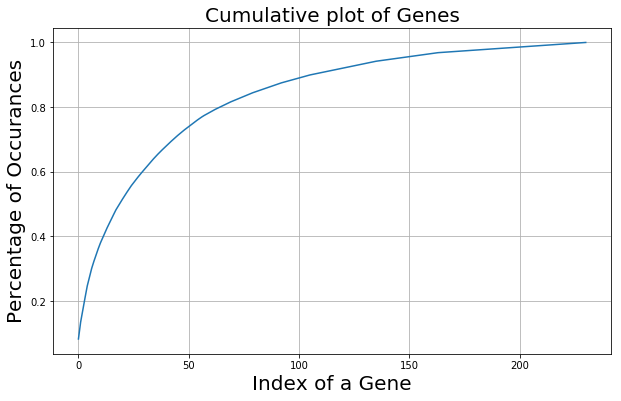

In [41]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.figure(figsize = (10, 6))
plt.plot(np.cumsum(h))
plt.title("Cumulative plot of Genes", fontsize = 20)
plt.xlabel('Index of a Gene', fontsize = 20)
plt.ylabel('Percentage of Occurances', fontsize = 20)
plt.grid()
plt.show()

<p> <b>Q3.</b> How to featurize this Gene feature ?</p>
<ol><li>Response Coding</li><li>One-hot Coding</li></ol>

In [42]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(response_coded_values(alpha, "Gene", TrainData))
# test gene feature
test_gene_feature_responseCoding = np.array(response_coded_values(alpha, "Gene", TestData))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(response_coded_values(alpha, "Gene", CV_Data))

In [43]:
# we convert each row values such that they sum to 1  
train_gene_feature_responseCoding = (train_gene_feature_responseCoding.T/train_gene_feature_responseCoding.sum(axis=1)).T
test_gene_feature_responseCoding = (test_gene_feature_responseCoding.T/test_gene_feature_responseCoding.sum(axis=1)).T
cv_gene_feature_responseCoding = (cv_gene_feature_responseCoding.T/cv_gene_feature_responseCoding.sum(axis=1)).T 

In [44]:
print("Size of response encoded features in train data = "+str(train_gene_feature_responseCoding.shape))
print("Size of response encoded features in test data = "+str(test_gene_feature_responseCoding.shape))
print("Size of response encoded features in CV data = "+str(cv_gene_feature_responseCoding.shape))

Size of response encoded features in train data = (2121, 9)
Size of response encoded features in test data = (664, 9)
Size of response encoded features in CV data = (531, 9)


In [45]:
geneVectorizer = CountVectorizer()
train_gene_feature_onehotCoding = geneVectorizer.fit_transform(TrainData['Gene'])
test_gene_feature_onehotCoding = geneVectorizer.transform(TestData['Gene'])
cv_gene_feature_onehotCoding = geneVectorizer.transform(CV_Data['Gene'])

In [46]:
print("Size of one-hot encoded features in train data = "+str(train_gene_feature_onehotCoding.shape))
print("Size of one-hot encoded features in test data = "+str(test_gene_feature_onehotCoding.shape))
print("Size of one-hot encoded features in CV data = "+str(cv_gene_feature_onehotCoding.shape))

Size of one-hot encoded features in train data = (2121, 231)
Size of one-hot encoded features in test data = (664, 231)
Size of one-hot encoded features in CV data = (531, 231)


<h3>Q4. How good is this gene feature in predicting y_i?</h3>
<p>There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.</p>

For alpha value of 1e-05 CV log loss = 1.3664557036424139
For alpha value of 0.0001 CV log loss = 1.2338743693775847
For alpha value of 0.001 CV log loss = 1.240161361283013
For alpha value of 0.01 CV log loss = 1.3480508759177392
For alpha value of 0.1 CV log loss = 1.4571446712648841
For alpha value of 1 CV log loss = 1.4943304880484825


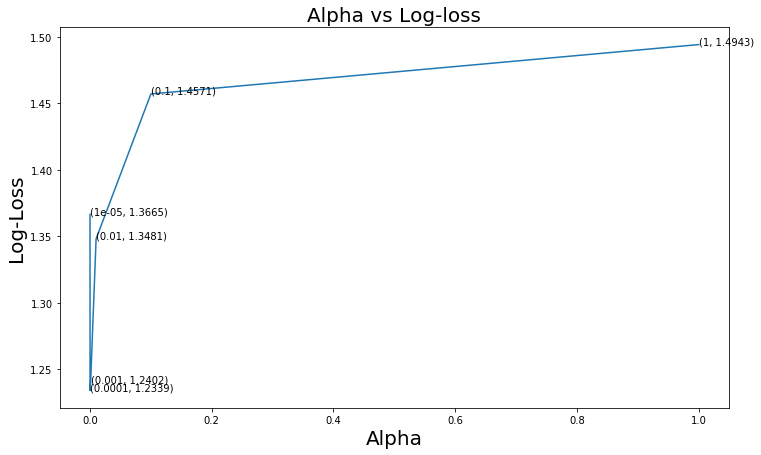

In [47]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, TrainDataLabels)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    #this is a cross-validation
    calib_clf.fit(train_gene_feature_onehotCoding, TrainDataLabels)
    predicted_y = calib_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_loss.append(log_loss(CV_Data_Labels, predicted_y, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CV_Data_Labels, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

In [48]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, TrainDataLabels)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(train_gene_feature_onehotCoding, TrainDataLabels)

predict_train = calib_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(TrainDataLabels, predict_train, labels=clf.classes_))

predict_cv = calib_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(CV_Data_Labels, predict_cv, labels=clf.classes_))

predict_test = calib_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(TestLabels, predict_test, labels=clf.classes_))

For values of best alpha =  0.0001 the train log loss =: 1.0201550004769964
For values of best alpha =  0.0001 the CV log loss =: 1.2338743693775847
For values of best alpha =  0.0001 the test log loss =: 1.2192205191626133


<h3>Q5. Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</h3>
<p> <b>Ans:</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error.</p>

In [49]:
print("Ques: How many common gene features are there in train, cv and test data?")
gene_common_in_test = TestData[TestData["Gene"].isin(TrainData["Gene"])].shape[0]
gene_common_in_cv = CV_Data[CV_Data["Gene"].isin(TrainData["Gene"])].shape[0]
print("Ans:")
print("Percentage of common gene features in test and train data = "+str(np.round((gene_common_in_test/TestData.shape[0])*100, 2))+"%")
#it prints: Out of total features in test data, how many features are also present in train data
print("Percentage of common gene features in CV and train data = "+str(np.round((gene_common_in_cv/CV_Data.shape[0])*100, 2))+"%")
#it prints: Out of total features in cv data, how many features are also present in train data

Ques: How many common gene features are there in train, cv and test data?
Ans:
Percentage of common gene features in test and train data = 96.84%
Percentage of common gene features in CV and train data = 96.61%


<h1>Univariate Analysis on Variation Feature</h1>

<p>Q1. Variation, What type of feature is it?</p>
<p><b>Ans.</b> Variation is a categorical variable</p>
<p>Q2. How many categories are there?</p>

In [50]:
unique_variation = TrainData["Variation"].value_counts()
print("Number of Unique variations = "+str(unique_variation.shape[0]))
print(unique_variation.head(10))

Number of Unique variations = 1926
Truncating_Mutations    57
Amplification           49
Deletion                40
Fusions                 25
G12V                     3
Q61H                     3
Overexpression           3
E17K                     3
V321M                    2
P130S                    2
Name: Variation, dtype: int64


In [51]:
print("Ans: There are", unique_variation.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows:")

Ans: There are 1926 different categories of variations in the train data, and they are distibuted as follows:


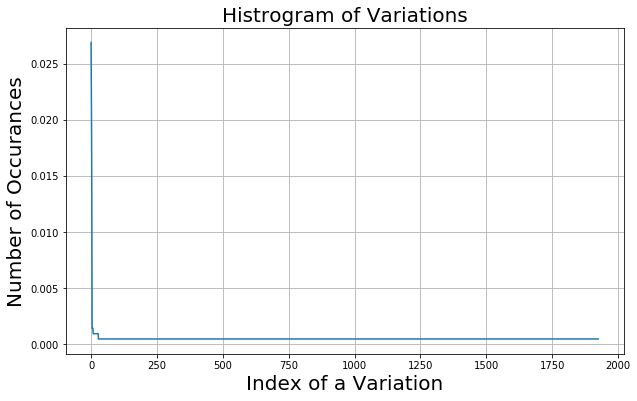

In [52]:
s = sum(unique_variation.values)
h = unique_variation.values/s
plt.figure(figsize = (10, 6))
plt.plot(h)
plt.title("Histrogram of Variations", fontsize = 20)
plt.xlabel('Index of a Variation', fontsize = 20)
plt.ylabel('Number of Occurances', fontsize = 20)
plt.grid()
plt.show()

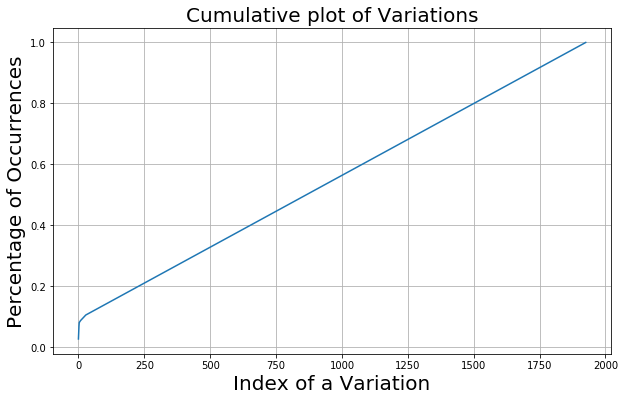

In [53]:
s = sum(unique_variation.values)
h = unique_variation.values/s
c = np.cumsum(h)
plt.figure(figsize = (10, 6))
plt.plot(c)
plt.title("Cumulative plot of Variations", fontsize = 20)
plt.xlabel('Index of a Variation', fontsize = 20)
plt.ylabel('Percentage of Occurrences', fontsize = 20)
plt.grid()
plt.show()

<p> <b>Q3.</b> How to featurize this Variation feature ?</p>
<ol><li>Response Coding</li><li>One-hot Coding</li></ol>

In [54]:
#response-coding of the variation feature
# alpha is used for laplace smoothing
alpha = 1
# train variation feature
train_variation_feature_responseCoding = np.array(response_coded_values(alpha, "Variation", TrainData))
# test variation feature
test_variation_feature_responseCoding = np.array(response_coded_values(alpha, "Variation", TestData))
# cross validation variation feature
cv_variation_feature_responseCoding = np.array(response_coded_values(alpha, "Variation", CV_Data))

In [55]:
# we convert each row values such that they sum to 1  
train_variation_feature_responseCoding = (train_variation_feature_responseCoding.T/train_variation_feature_responseCoding.sum(axis=1)).T
test_variation_feature_responseCoding = (test_variation_feature_responseCoding.T/test_variation_feature_responseCoding.sum(axis=1)).T
cv_variation_feature_responseCoding = (cv_variation_feature_responseCoding.T/cv_variation_feature_responseCoding.sum(axis=1)).T  

In [56]:
print("Size of response encoded features in train data = "+str(train_variation_feature_responseCoding.shape))
print("Size of response encoded features in test data = "+str(test_variation_feature_responseCoding.shape))
print("Size of response encoded features in CV data = "+str(cv_variation_feature_responseCoding.shape))

Size of response encoded features in train data = (2121, 9)
Size of response encoded features in test data = (664, 9)
Size of response encoded features in CV data = (531, 9)


In [57]:
variationVectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variationVectorizer.fit_transform(TrainData['Variation'])
test_variation_feature_onehotCoding = variationVectorizer.transform(TestData['Variation'])
cv_variation_feature_onehotCoding = variationVectorizer.transform(CV_Data['Variation'])

In [58]:
print("Size of one-hot encoded features in train data = "+str(train_variation_feature_onehotCoding.shape))
print("Size of one-hot encoded features in test data = "+str(test_variation_feature_onehotCoding.shape))
print("Size of one-hot encoded features in CV data = "+str(cv_variation_feature_onehotCoding.shape))

Size of one-hot encoded features in train data = (2121, 1960)
Size of one-hot encoded features in test data = (664, 1960)
Size of one-hot encoded features in CV data = (531, 1960)


<h3>Q4. How good is this Variation feature in predicting y_i?</h3>
<p>There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Variation feature (one hot encoded) to predict y_i.</p>

For alpha value of 1e-05 CV log loss = 1.7141515246311514
For alpha value of 0.0001 CV log loss = 1.6944516886030232
For alpha value of 0.001 CV log loss = 1.6941554287218221
For alpha value of 0.01 CV log loss = 1.7079272121104785
For alpha value of 0.1 CV log loss = 1.7244541941635538
For alpha value of 1 CV log loss = 1.7265074461494674


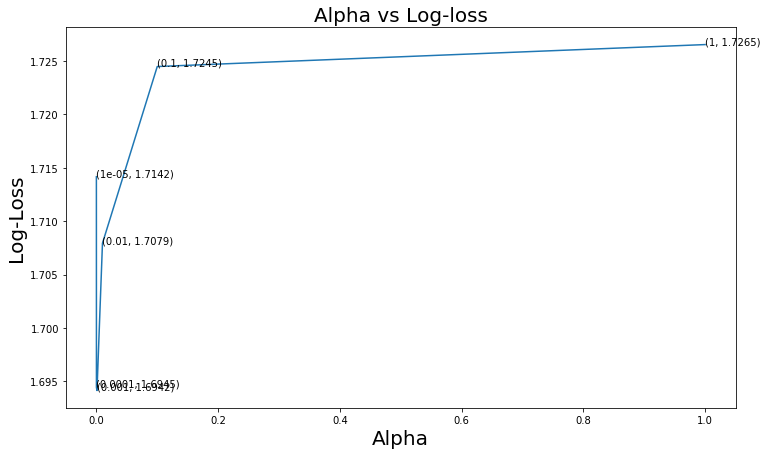

In [59]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, TrainDataLabels)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(train_variation_feature_onehotCoding, TrainDataLabels)
    predicted_y = calib_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_loss.append(log_loss(CV_Data_Labels, predicted_y, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CV_Data_Labels, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

In [60]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, TrainDataLabels)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(train_variation_feature_onehotCoding, TrainDataLabels)

predict_train = calib_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(TrainDataLabels, predict_train, labels=clf.classes_))

predict_cv = calib_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(CV_Data_Labels, predict_cv, labels=clf.classes_))

predict_test = calib_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(TestLabels, predict_test, labels=clf.classes_))

For values of best alpha =  0.001 the train log loss =: 1.052420759553998
For values of best alpha =  0.001 the CV log loss =: 1.6941554287218221
For values of best alpha =  0.001 the test log loss =: 1.7246954865100943


<h3>Q5. Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</h3>
<p> <b>Ans:</b> Not sure, let's check it out.</p>

In [61]:
print("Ques: How many common variation features are there in train, cv and test data?")
variation_common_in_test = TestData[TestData["Variation"].isin(TrainData["Variation"])].shape[0]
variation_common_in_cv = CV_Data[CV_Data["Variation"].isin(TrainData["Variation"])].shape[0]
print("Ans:")
print("Percentage of common Variation features in test and train data = "+str(np.round((variation_common_in_test/TestData.shape[0])*100, 2))+"%")
#it prints: Out of total features in test data, how many features are also present in train data
print("Percentage of common Variation features in CV and train data = "+str(np.round((variation_common_in_cv/CV_Data.shape[0])*100, 2))+"%")
#it prints: Out of total features in cv data, how many features are also present in train data

Ques: How many common variation features are there in train, cv and test data?
Ans:
Percentage of common Variation features in test and train data = 10.39%
Percentage of common Variation features in CV and train data = 10.55%


<h1>Univariate Analysis on Text Feature</h1>

### How many unique words are present in train data?

In [62]:
dictt = defaultdict(int)
for index, row in TrainData.iterrows():
    for word in row['Text'].split():
        dictt[word] += 1
print("Number of unique words in train data = "+str(len(dictt.keys())))

Number of unique words in train data = 126077


<p>How to featurize text field?</p>
<ol>
    <li>Response Coding</li>
    <li>TFIDF</li>
</ol>

<p><b>Response Coding</b></p>

In [63]:
def TextWordOccurrenceDict(cls_text):
    dictt = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['Text'].split():
            dictt[word] += 1
    return dictt

In [64]:
dict_list = []
for i in range(1,10):
    cls_text = TrainData[TrainData['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(TextWordOccurrenceDict(cls_text))
    # append it to dict_list
# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = TextWordOccurrenceDict(TrainData)

In [65]:
def createResponseCodedText(df):
    alpha = 10
    textFeatueResponseCode = np.zeros((df.shape[0], 9))
    for i in range(0,9):
        rowIndex = 0
        for index, rows in df.iterrows():
            sumProbability = 0
            for word in row["Text"].split():
                sumProbability += math.log(((dict_list[i].get(word,0))+alpha)/((total_dict.get(word,0))+(9*alpha)))
            textFeatueResponseCode[rowIndex][i] = math.exp(sumProbability/len(row["Text"].split()))
            rowIndex += 1
    return textFeatueResponseCode

In [66]:
#response coding of text features
train_text_feature_responseCoding  = createResponseCodedText(TrainData)
test_text_feature_responseCoding  = createResponseCodedText(TestData)
cv_text_feature_responseCoding  = createResponseCodedText(CV_Data)

In [67]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T   
    
    
# matx = [[1, 2],
#        [3, 4]]
# matx.T = [[1, 3],
#           [2, 4]]
# matx.sum(axis = 1)  axis=0 corresponds to columns and axis=1 corresponds to rows in two diamensional array
# matx.sum(axix =1) = [[3, 7]]
# (matx.T)/(matx.sum(axis=1)) = [[1/3, 3/7]
#                               [2/3, 4/7]]

# (matx.T)/(matx.sum(axis=1)).T = [[1/3, 2/3]
#                                  [3/7, 4/7]]
# sum of row elements = 1

In [68]:
print("Size of response coded text feature of Train Data = "+str(train_text_feature_responseCoding.shape))
print("Size of response coded text feature of Test Data = "+str(test_text_feature_responseCoding.shape))
print("Size of response coded text feature of CV Data = "+str(cv_text_feature_responseCoding.shape))

Size of response coded text feature of Train Data = (2121, 9)
Size of response coded text feature of Test Data = (664, 9)
Size of response coded text feature of CV Data = (531, 9)


<p><b>TFIDF</b></p>

In [69]:
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,2), stop_words = "english", min_df = 3, max_features = 100000)

train_text_feature_tfidf = tfidf_vectorizer.fit_transform(TrainData['Text'])
train_text_feature_tfidf = StandardScaler(with_mean = False).fit_transform(train_text_feature_tfidf)

test_text_feature_tfidf = tfidf_vectorizer.transform(TestData['Text'])
test_text_feature_tfidf = StandardScaler(with_mean = False).fit_transform(test_text_feature_tfidf)

cv_text_feature_tfidf = tfidf_vectorizer.transform(CV_Data['Text'])
cv_text_feature_tfidf = StandardScaler(with_mean = False).fit_transform(cv_text_feature_tfidf)

In [70]:
print("Size of TFIDF coded text feature of Train Data = "+str(train_text_feature_tfidf.shape))
print("Size of TFIDF coded text feature of Test Data = "+str(test_text_feature_tfidf.shape))
print("Size of TFIDF coded text feature of CV Data = "+str(cv_text_feature_tfidf.shape))

Size of TFIDF coded text feature of Train Data = (2121, 100000)
Size of TFIDF coded text feature of Test Data = (664, 100000)
Size of TFIDF coded text feature of CV Data = (531, 100000)


### How are word frequencies distributed?

In [71]:
count_vec = CountVectorizer(min_df = 3)
TrainWordOccurrences = count_vec.fit_transform(TrainData['Text'])
# getting all the feature names (words)
TrainFeatures= count_vec.get_feature_names()

# TrainWordOccurrences.sum(axis=0).A1 will sum every column and returns (1*number of features) vector
wordOccurrenceDictionary = dict(zip(TrainFeatures,TrainWordOccurrences.sum(axis=0).A1))

In [72]:
sortedWordOccurrenceDict = dict(sorted(wordOccurrenceDictionary.items(), key=lambda x: x[1] , reverse=True))

In [73]:
sortedWordOccurrenceDictList = np.array(list(sortedWordOccurrenceDict.values()))

In [74]:
NoOfWord_Occurrence = Counter(sortedWordOccurrenceDictList) 
#counter simply takes a list then it prints a dictionary. In that dictionary, keys are the number of elements and its values 
#are the number of times that element is occurring in that list.

In [75]:
print(NoOfWord_Occurrence)
#this will print a dictionary where keys are number of word and its values are the number of times that word in appearing in
#train data. For eg, in below dictionary 3 words are occurring 5316 times, 4 words are occurring 3385 times and so on.

Counter({3: 4768, 4: 3476, 5: 2804, 6: 2549, 7: 2038, 8: 1908, 10: 1754, 12: 1541, 9: 1499, 14: 1305, 16: 973, 11: 900, 13: 794, 15: 767, 18: 642, 20: 640, 17: 575, 21: 563, 19: 525, 22: 497, 24: 484, 30: 414, 23: 399, 25: 398, 28: 366, 37: 348, 27: 340, 26: 310, 33: 308, 32: 303, 36: 299, 31: 272, 47: 269, 29: 264, 35: 262, 40: 240, 42: 237, 34: 223, 48: 206, 38: 204, 43: 200, 45: 185, 39: 185, 44: 182, 41: 170, 46: 164, 50: 159, 56: 155, 51: 153, 60: 150, 57: 140, 53: 139, 49: 137, 55: 132, 54: 130, 52: 124, 64: 122, 63: 117, 58: 116, 62: 113, 72: 107, 59: 107, 67: 104, 70: 101, 68: 101, 75: 100, 61: 96, 66: 92, 65: 92, 86: 90, 73: 89, 84: 88, 77: 88, 74: 87, 71: 87, 69: 84, 81: 83, 76: 80, 80: 78, 88: 75, 94: 73, 85: 73, 92: 69, 103: 67, 83: 67, 79: 65, 100: 63, 82: 63, 87: 62, 91: 61, 78: 61, 89: 60, 98: 59, 97: 58, 90: 57, 93: 55, 101: 54, 96: 54, 108: 53, 105: 53, 95: 52, 99: 51, 116: 50, 126: 49, 120: 49, 114: 49, 141: 48, 112: 48, 111: 48, 109: 48, 118: 47, 140: 45, 119: 45, 14

### Is the text feature useful in predicitng y_i?

For alpha value of 1e-05 CV log loss = 1.5064758775968379
For alpha value of 0.0001 CV log loss = 1.4700399302424787
For alpha value of 0.001 CV log loss = 1.4692512602174146
For alpha value of 0.01 CV log loss = 1.461566819403949
For alpha value of 0.1 CV log loss = 1.4747612683435707
For alpha value of 1 CV log loss = 1.3779810481900128
For alpha value of 10 CV log loss = 1.1367292578836257
For alpha value of 15 CV log loss = 1.1365034460152175
For alpha value of 20 CV log loss = 1.1423904297122562
For alpha value of 40 CV log loss = 1.1722490341971343


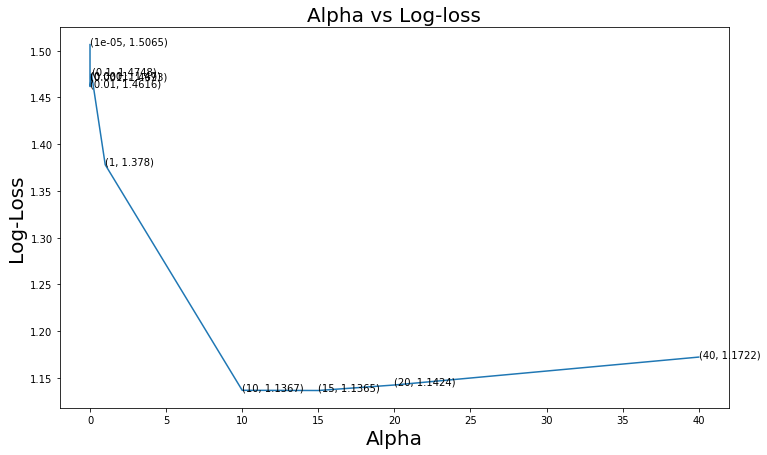

In [76]:
alpha = [10 ** x for x in range(-5, 2)]
alpha.append(15)
alpha.append(20)
alpha.append(40)

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_tfidf, TrainDataLabels)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(train_text_feature_tfidf, TrainDataLabels)
    predicted_y = calib_clf.predict_proba(cv_text_feature_tfidf)
    cv_log_loss.append(log_loss(CV_Data_Labels, predicted_y, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CV_Data_Labels, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

In [77]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_tfidf, TrainDataLabels)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(train_text_feature_tfidf, TrainDataLabels)

predict_train = calib_clf.predict_proba(train_text_feature_tfidf)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(TrainDataLabels, predict_train, labels=clf.classes_))

predict_cv = calib_clf.predict_proba(cv_text_feature_tfidf)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(CV_Data_Labels, predict_cv, labels=clf.classes_))

predict_test = calib_clf.predict_proba(test_text_feature_tfidf)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(TestLabels, predict_test, labels=clf.classes_))

For values of best alpha =  15 the train log loss =: 0.6816928497360148
For values of best alpha =  15 the CV log loss =: 1.1365034460152175
For values of best alpha =  15 the test log loss =: 1.0888379907457424


### Is the text feature stable across train, test and CV datasets?

In [78]:
def checkingCommonFeatures(df):
    count_vect = CountVectorizer(min_df = 3)
    BoWMatrx = count_vect.fit_transform(df["Text"])
    BoWMatrxFeatures = count_vect.get_feature_names()
    BoWMatrxFeaturesUnique = len(set(BoWMatrxFeatures))
    commonFeatures = len(set(TrainFeatures) & set(BoWMatrxFeatures))
    return BoWMatrxFeaturesUnique, commonFeatures

In [79]:
count_vect = CountVectorizer(min_df = 3)
BoWMatrx = count_vect.fit_transform(TestData["Text"])
BoWMatrxFeatures = count_vect.get_feature_names()

In [80]:
len1, len2 = checkingCommonFeatures(TestData)
print("Percentage of common features in train and test data = "+str(np.round((len2/len1)*100, 4))+"%")
#it prints: Out of total features in test data, how many features are also present in train data
len3, len4 = checkingCommonFeatures(CV_Data)
print("Percentage of common features in train and CV data = "+str(np.round((len4/len3)*100, 4))+"%")
#it prints: Out of total features in CV data, how many features are also present in train data

Percentage of common features in train and test data = 95.6438%
Percentage of common features in train and CV data = 97.5012%


<h1>Machine Learning Models</h1>

In [ ]:
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def getImportantFeatures(indices, gene, variation, text, noOfFeatures):
    gene_vect = CountVectorizer()
    var_vect = CountVectorizer()
    text_vect = TfidfVectorizer(ngram_range = (1,2), stop_words = "english", min_df = 3, max_features = 100000)
    
    geneVect = gene_vect.fit(TrainData['Gene'])
    varVect  = var_vect.fit(TrainData['Variation'])
    textVect = text_vect.fit(TrainData['Text'])
    
    gene_features = gene_vect.get_feature_names()
    variation_features = varVect.get_feature_names()
    text_features = text_vect.get_feature_names()
    
    gene_feat_len = len(gene_features)
    var_feat_len = len(variation_features)
    
    First = [x1 for x1 in range(0, 491, 10)]
    del First[1]
    Second = [x2 for x2 in range(1, 492, 10)]
    del Second[1]
    Third = [x3 for x3 in range(2, 493, 10)]
    del Third[1]
    
    word_present = 0
    for i, v in enumerate(indices):
        if v < gene_feat_len:
            word = gene_features[v]
            
            if word == gene:
                word_present += 1
                
                if i in First:
                    print("{}st Gene feature [{}] is present in query point".format(i+1, word))
                
                elif i in Second:
                    print("{}nd Gene feature [{}] is present in query point".format(i+1, word))
                
                elif i in Third:
                    print("{}rd Gene feature [{}] is present in query point".format(i+1, word))
                    
                else:
                    print("{}th Gen feature [{}] is present in query point".format(i+1, word))
                    
        elif v < gene_feat_len + var_feat_len:
            word = variation_features[v - gene_feat_len]
            
            if word == variation:
                word_present += 1
                if i in First:
                    print("{}st Variation feature [{}] is present in query point".format(i+1, word))
                
                elif i in Second:
                    print("{}nd Variation feature [{}] is present in query point".format(i+1, word))
                
                elif i in Third:
                    print("{}rd Variation feature [{}] is present in query point".format(i+1, word))
                    
                else:
                    print("{}th Variation feature [{}] is present in query point".format(i+1, word))
        else:
            word = text_features[v - (gene_feat_len + var_feat_len)]
            
            if word in text.split():
                word_present += 1
                
                if i in First:
                    print("{}st Text feature [{}] is present in query point".format(i+1, word))
                
                elif i in Second:
                    print("{}nd Text feature [{}] is present in query point".format(i+1, word))
                
                elif i in Third:
                    print("{}rd Text feature [{}] is present in query point".format(i+1, word))
                    
                else:
                    print("{}th Text feature [{}] is present in query point".format(i+1, word))
                    
    print("-"*63)                
    print("Out of the top "+str(noOfFeatures)+" features "+str(word_present)+" are present in query point")

In [40]:
table = pd.DataFrame(columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"])

<h1>Stacking three types of classifier</h1>

In [84]:
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_oneHotEncode = hstack((train_gene_feature_onehotCoding, train_variation_feature_onehotCoding))
cv_gene_var_oneHotEncode = hstack((cv_gene_feature_onehotCoding, cv_variation_feature_onehotCoding))
test_gene_var_oneHotEncode = hstack((test_gene_feature_onehotCoding, test_variation_feature_onehotCoding))

Train_X = hstack((train_gene_var_oneHotEncode, train_text_feature_tfidf))
Train_X = Train_X.tocsr()
Train_Y = np.array(list(TrainDataLabels))

CV_X = hstack((cv_gene_var_oneHotEncode, cv_text_feature_tfidf))
CV_X = CV_X.tocsr()
CV_Y = np.array(list(CV_Data_Labels))

Test_X = hstack((test_gene_var_oneHotEncode, test_text_feature_tfidf))
Test_X = Test_X.tocsr()
Test_Y = np.array(list(TestLabels))

In [85]:
print("Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Train Data = "+str(Train_X.shape))
print("Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for CV Data = "+str(CV_X.shape))
print("Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Test Data = "+str(Test_X.shape))

Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Train Data = (2121, 102191)
Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for CV Data = (531, 102191)
Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Test Data = (664, 102191)


In [86]:
train_gene_var_responseCoded = np.hstack((train_gene_feature_responseCoding, train_variation_feature_responseCoding))
cv_gene_var_responseCoded = np.hstack((cv_gene_feature_responseCoding, cv_variation_feature_responseCoding))
test_gene_var_responseCoded = np.hstack((test_gene_feature_responseCoding, test_variation_feature_responseCoding))

Train_X_ResponseCoded = np.hstack((train_gene_var_responseCoded, train_text_feature_responseCoding))
CV_X_ResponseCoded = np.hstack((cv_gene_var_responseCoded, cv_text_feature_responseCoding))
Test_X_ResponseCoded = np.hstack((test_gene_var_responseCoded, test_text_feature_responseCoding))

# Train_X_ResponseCoded = StandardScaler().fit_transform(Train_X_ResponseCoded)
# CV_X_ResponseCoded = StandardScaler().fit_transform(CV_X_ResponseCoded)
# Test_X_ResponseCoded = StandardScaler().fit_transform(Test_X_ResponseCoded)

#Here, Response coded vectors are not standardized because all the column are just probabilities between 0 and 1 and therefore,
#all are in same scale.

In [87]:
print("Shape of Response Coded Gene and Variation, TFIDF text stacked vector for Train Data = "+str(Train_X_ResponseCoded.shape))
print("Shape of Response Coded Gene and Variation, TFIDF text stacked vector for CV Data = "+str(CV_X_ResponseCoded.shape))
print("Shape of Response Coded Gene and Variation, TFIDF text stacked vector for Test Data = "+str(Test_X_ResponseCoded.shape))

Shape of Response Coded Gene and Variation, TFIDF text stacked vector for Train Data = (2121, 27)
Shape of Response Coded Gene and Variation, TFIDF text stacked vector for CV Data = (531, 27)
Shape of Response Coded Gene and Variation, TFIDF text stacked vector for Test Data = (664, 27)


## Base Line Models

### Naive Bayes

#### Hyper-Parameter Tuning

For alpha value of 1e-05 CV log loss = 1.3471712144052246
For alpha value of 0.0001 CV log loss = 1.3504495385459239
For alpha value of 0.001 CV log loss = 1.3491828952854628
For alpha value of 0.01 CV log loss = 1.3560756526469306
For alpha value of 0.1 CV log loss = 1.357974432285551
For alpha value of 1 CV log loss = 1.372217919431397
For alpha value of 10 CV log loss = 1.3936886399206103
For alpha value of 100 CV log loss = 1.4600569331000073
For alpha value of 1000 CV log loss = 1.519593771555386
For alpha value of 10000 CV log loss = 1.5207830444039192


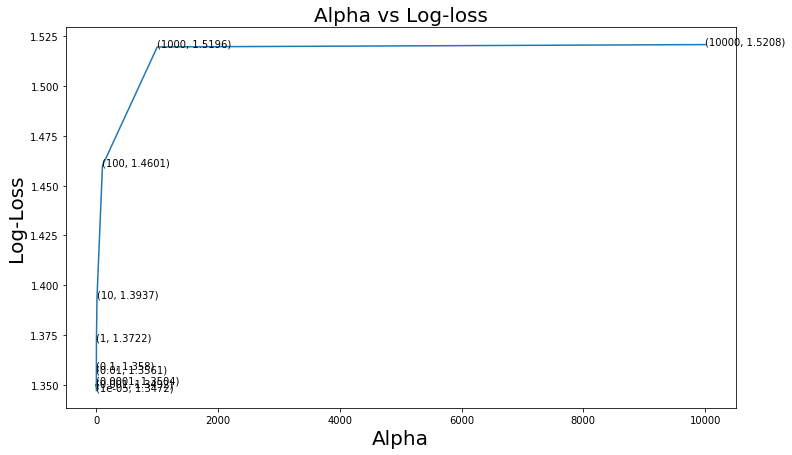

In [117]:
alpha = [10**x for x in range(-5, 5)]

cv_log_loss = []
for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(Train_X, Train_Y)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(Train_X, Train_Y)
    predicted_y = calib_clf.predict_proba(CV_X)
    cv_log_loss.append(log_loss(CV_Y, predicted_y, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CV_Y, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

<h2>Testing with best hyper-parameter</h2>

In [118]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = MultinomialNB(alpha=best_alpha)
clf.fit(Train_X, Train_Y)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(Train_X, Train_Y)

predict_train = calib_clf.predict_proba(Train_X)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(Train_Y, predict_train, labels=clf.classes_))

predict_cv = calib_clf.predict_proba(CV_X)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(CV_Y, predict_cv, labels=clf.classes_))

predict_test = calib_clf.predict_proba(Test_X)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(Test_Y, predict_test, labels=clf.classes_))

For values of best alpha =  1e-05 the train log loss =: 0.903102740053625
For values of best alpha =  1e-05 the CV log loss =: 1.3471712144052246
For values of best alpha =  1e-05 the test log loss =: 1.2976410460598533


In [119]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(calib_clf.predict(CV_X) - CV_Y)/CV_X.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(calib_clf.predict(Test_X) - Test_Y)/Test_X.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 42.75%
Percentage of mis-classified for Test points = 39.46%


In [41]:
table = table.append(pd.DataFrame([["Naive Bayes", 0.9031, 1.3471, 1.2976, "42.75%", "39.46%", "GoodFit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

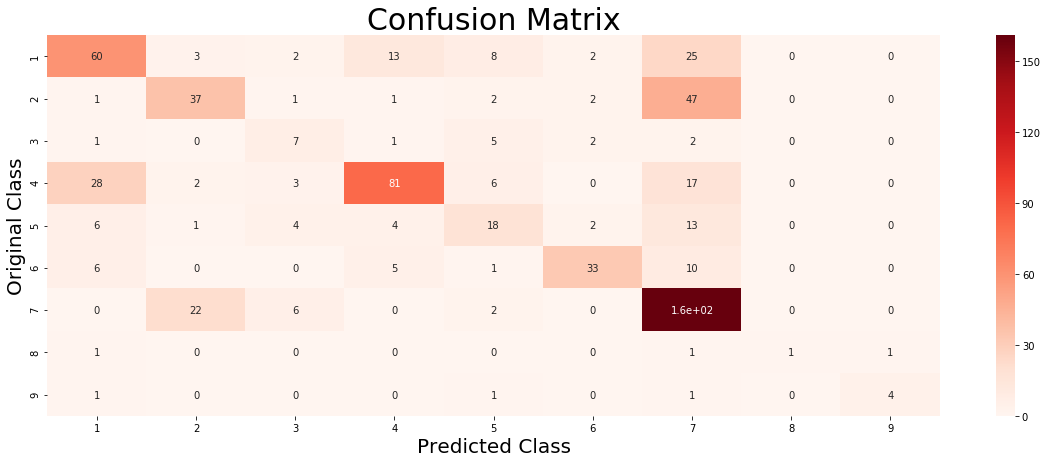

-----------------------------------------------------------------------------------------------------------------------------


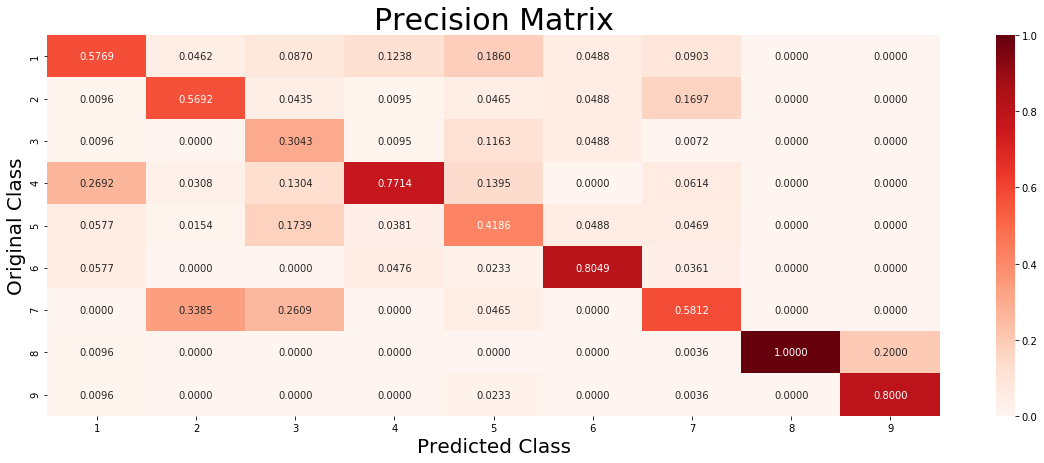

-----------------------------------------------------------------------------------------------------------------------------


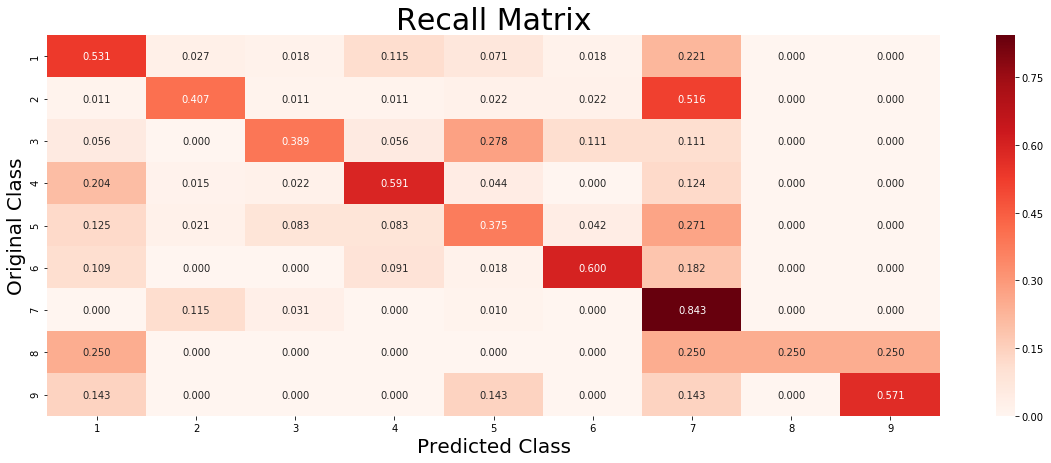

In [120]:
print_confusionMatrix(Test_Y, calib_clf.predict(Test_X))

<h2>Checking first 100 important features for correctly classified test point</h2>

In [122]:
testDataPoint = 5
no_feature = 100
predicted_cls = calib_clf.predict(Test_X[testDataPoint])
TrueLabel = Test_Y[testDataPoint]
predicted_prob = np.round(calib_clf.predict_proba(Test_X[testDataPoint]), 4)
print("Predicted Class label for test point = "+str(predicted_cls[0]))
print("Predicted Probabilities for test point = "+str(predicted_prob))
print("True class label for test point = "+str(TrueLabel))
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*63)
getImportantFeatures(indices[0], TestData.iloc[testDataPoint]["Gene"], TestData.iloc[testDataPoint]["Variation"], TestData.iloc[testDataPoint]["Text"], no_feature)

Predicted Class label for test point = 4
Predicted Probabilities for test point = [[0.0818 0.0835 0.0078 0.6667 0.038  0.0381 0.0758 0.0047 0.0035]]
True class label for test point = 4
---------------------------------------------------------------
1st Text feature [shown] is present in query point
2nd Text feature [results] is present in query point
3rd Text feature [protein] is present in query point
4th Text feature [described] is present in query point
5th Text feature [activity] is present in query point
6th Text feature [using] is present in query point
7th Text feature [proteins] is present in query point
8th Text feature [determined] is present in query point
9th Text feature [type] is present in query point
10th Text feature [analysis] is present in query point
11th Text feature [mutations] is present in query point
12th Text feature [important] is present in query point
13th Text feature [previously] is present in query point
14th Text feature [addition] is present in query p

<h2>Checking first 100 important features for incorrectly classified test point</h2>

In [124]:
testDataPoint = 10
no_feature = 100
predicted_cls = calib_clf.predict(Test_X[testDataPoint])
TrueLabel = Test_Y[testDataPoint]
predicted_prob = np.round(calib_clf.predict_proba(Test_X[testDataPoint]), 4)
print("Predicted Class label for test point = "+str(predicted_cls[0]))
print("Predicted Probabilities for test point ", end='')
print(predicted_prob[0])
print("True class label for test point = "+str(TrueLabel))
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*63)
getImportantFeatures(indices[0], TestData.iloc[testDataPoint]["Gene"], TestData.iloc[testDataPoint]["Variation"], TestData.iloc[testDataPoint]["Text"], no_feature)

Predicted Class label for test point = 5
Predicted Probabilities for test point [0.105  0.107  0.0101 0.1295 0.4922 0.049  0.0967 0.006  0.0044]
True class label for test point = 3
---------------------------------------------------------------
1st Text feature [results] is present in query point
2nd Text feature [based] is present in query point
3rd Text feature [introduction] is present in query point
4th Text feature [used] is present in query point
5th Text feature [data] is present in query point
6th Text feature [analysis] is present in query point
7th Text feature [discussion] is present in query point
8th Text feature [functional] is present in query point
9th Text feature [addition] is present in query point
10th Text feature [using] is present in query point
12th Text feature [assays] is present in query point
13th Text feature [table] is present in query point
14th Text feature [effect] is present in query point
16th Text feature [assay] is present in query point
17th Text f

### K Nearest Classification

#### Hyper-Parameter Tuning

For Neighbor value of 3 CV log loss = 1.7692214013523657
For Neighbor value of 5 CV log loss = 1.6754501759178058
For Neighbor value of 8 CV log loss = 1.6545776360047968
For Neighbor value of 13 CV log loss = 1.641749372341594
For Neighbor value of 23 CV log loss = 1.7328293508503723
For Neighbor value of 35 CV log loss = 1.766035963843943
For Neighbor value of 51 CV log loss = 1.8028255611665078
For Neighbor value of 71 CV log loss = 1.6429965277783
For Neighbor value of 95 CV log loss = 1.5207840245105297
For Neighbor value of 121 CV log loss = 1.486401438577594
For Neighbor value of 151 CV log loss = 1.5069418199773952
For Neighbor value of 181 CV log loss = 1.5209270496094205
For Neighbor value of 221 CV log loss = 1.5922847082821472


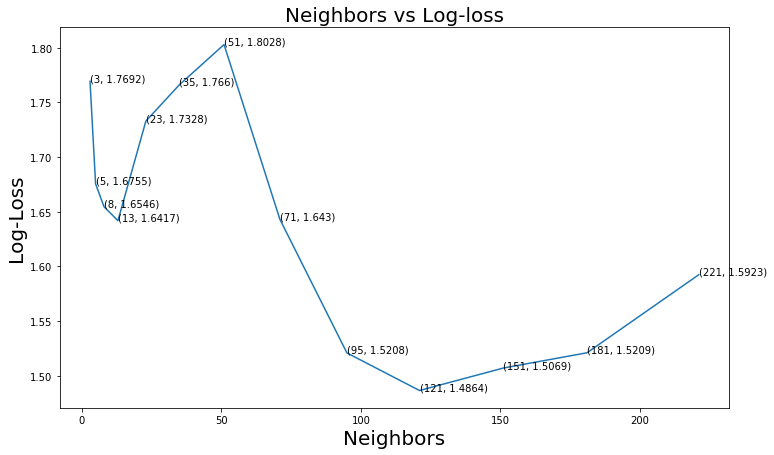

In [126]:
neighbors = [3, 5, 8, 13, 23, 35, 51, 71, 95, 121, 151, 181, 221]

cv_log_loss = []
for i in neighbors:
    clf = KNeighborsClassifier(n_neighbors = i, n_jobs = -1)
    clf.fit(Train_X_ResponseCoded, Train_Y)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(Train_X_ResponseCoded, Train_Y)
    predicted_y = calib_clf.predict_proba(CV_X_ResponseCoded)
    cv_log_loss.append(log_loss(CV_Y, predicted_y, labels=clf.classes_))
    print("For Neighbor value of "+str(i)+" CV log loss = "+str(log_loss(CV_Y, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(neighbors, cv_log_loss)
for xy in zip(neighbors, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Neighbors vs Log-loss", fontsize = 20)
plt.xlabel("Neighbors", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

<h2>Testing with best hyper-parameter</h2>

In [127]:
best_neighbors = neighbors[np.argmin(cv_log_loss)]
clf = KNeighborsClassifier(n_neighbors = best_neighbors, n_jobs = -1)
clf.fit(Train_X_ResponseCoded, Train_Y)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(Train_X_ResponseCoded, Train_Y)

predict_train = calib_clf.predict_proba(Train_X_ResponseCoded)
print('For values of best neighbors = ', best_neighbors, "the train log loss =:",log_loss(Train_Y, predict_train, labels=clf.classes_))

predict_cv = calib_clf.predict_proba(CV_X_ResponseCoded)
print('For values of best neighbors = ', best_neighbors, "the CV log loss =:",log_loss(CV_Y, predict_cv, labels=clf.classes_))

predict_test = calib_clf.predict_proba(Test_X_ResponseCoded)
print('For values of best neighbors = ', best_neighbors, "the test log loss =:",log_loss(Test_Y, predict_test, labels=clf.classes_))

For values of best neighbors =  121 the train log loss =: 0.09521210390493469
For values of best neighbors =  121 the CV log loss =: 1.486401438577594
For values of best neighbors =  121 the test log loss =: 1.5292688269258228


In [141]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(calib_clf.predict(CV_X_ResponseCoded) - CV_Y)/CV_X_ResponseCoded.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(calib_clf.predict(Test_X_ResponseCoded) - Test_Y)/Test_X_ResponseCoded.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 45.39%
Percentage of mis-classified for Test points = 44.88%


In [42]:
table = table.append(pd.DataFrame([["KNN", 0.0952, 1.4864, 1.529, "45.39%", "44.88%", "OverFit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

C:\Users\GauravP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


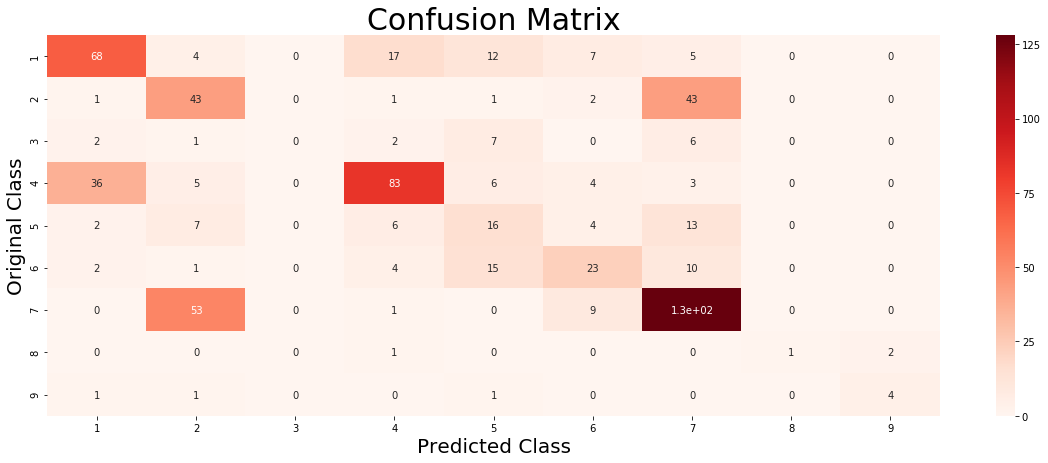

-----------------------------------------------------------------------------------------------------------------------------


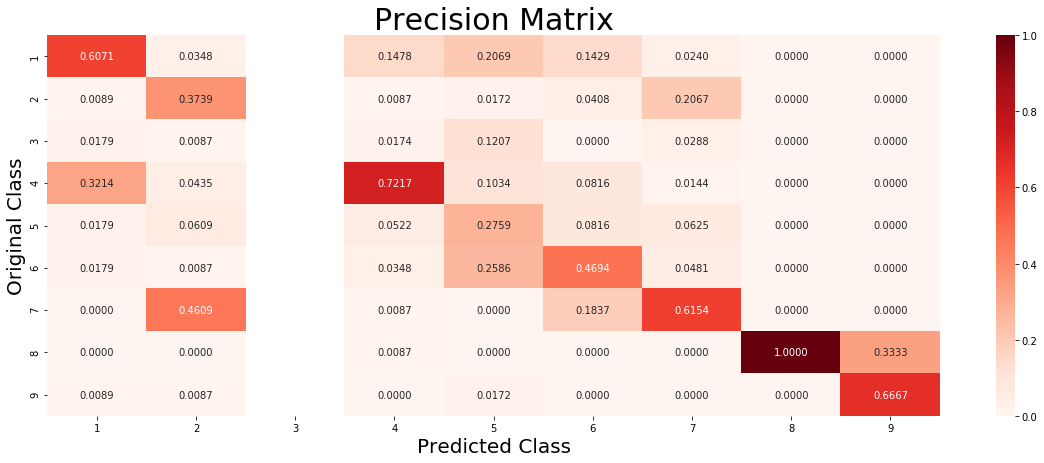

-----------------------------------------------------------------------------------------------------------------------------


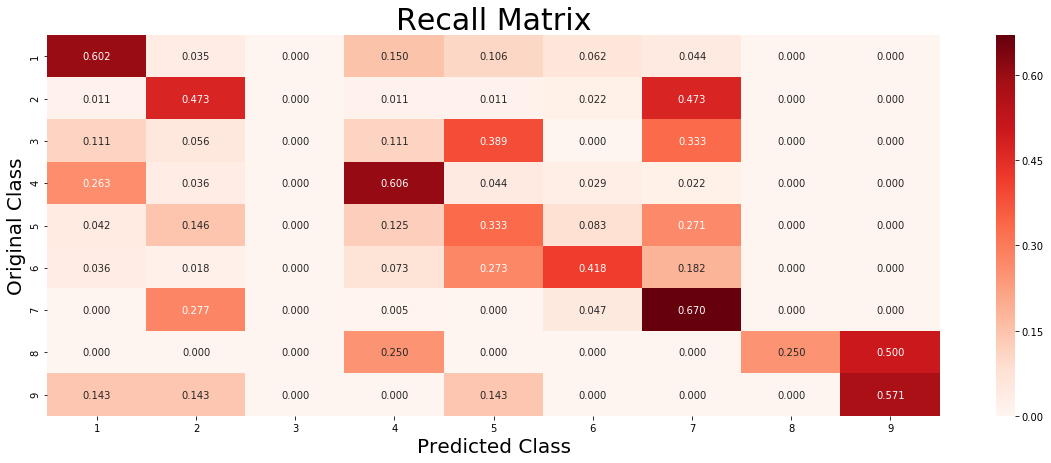

In [130]:
print_confusionMatrix(Test_Y, calib_clf.predict(Test_X_ResponseCoded))

<h2>Checking Nearest Neighbors for correctly classified point</h2>

In [131]:
testDataPoint = 35
predicted_cls = calib_clf.predict(Test_X_ResponseCoded[testDataPoint].reshape(1, -1)) #it will convert vector into 2D.
TrueLabel = Test_Y[testDataPoint]
predicted_prob = np.round(calib_clf.predict_proba(Test_X_ResponseCoded[testDataPoint].reshape(1, -1)), 2)
print("Predicted Class label for test point = "+str(predicted_cls[0]))
print("Predicted Probabilities for test point ", end='')
print(predicted_prob[0])
print("True class label for test point = "+str(TrueLabel)+"\n")
nearest_neighbor_points = clf.kneighbors(Test_X_ResponseCoded[testDataPoint].reshape(1, -1), n_neighbors = best_neighbors, return_distance = False)
print("Labels of nearest neighbors to test points = "+str(Train_Y[nearest_neighbor_points][0]))
print("Class Label: Number of neighboring points = "+str(Counter(Train_Y[nearest_neighbor_points][0])))

Predicted Class label for test point = 4
Predicted Probabilities for test point [0.   0.01 0.   0.98 0.   0.01 0.   0.   0.  ]
True class label for test point = 4

Labels of nearest neighbors to test points = [4 4 4 4 4 4 4 4 4 4 1 2 4 4 7 6 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4]
Class Label: Number of neighboring points = Counter({4: 107, 1: 5, 3: 4, 2: 2, 7: 1, 6: 1, 5: 1})


<h2>Checking Nearest Neighbors for incorrectly classified point</h2>

In [142]:
testDataPoint = 100
predicted_cls = calib_clf.predict(Test_X_ResponseCoded[testDataPoint].reshape(1, -1)) #it will convert vector into 2D.
TrueLabel = Test_Y[testDataPoint]
predicted_prob = np.round(calib_clf.predict_proba(Test_X_ResponseCoded[testDataPoint].reshape(1, -1)), 2)
print("Predicted Class label for test point = "+str(predicted_cls[0]))
print("Predicted Probabilities for test point ", end='')
print(predicted_prob[0])
print("True class label for test point = "+str(TrueLabel)+"\n")
nearest_neighbor_points = clf.kneighbors(Test_X_ResponseCoded[testDataPoint].reshape(1, -1), n_neighbors = best_neighbors, return_distance = False)
print("The best value of nearest neighbors is "+str(best_neighbors)+" and class labels of those nearest neighbors to test points = "+str(Train_Y[nearest_neighbor_points][0])+"\n")
print("Class Label: Number of neighboring points = "+str(Counter(Train_Y[nearest_neighbor_points][0])))

Predicted Class label for test point = 1
Predicted Probabilities for test point [0.75 0.03 0.01 0.15 0.01 0.05 0.   0.01 0.  ]
True class label for test point = 4

The best value of nearest neighbors is 121 and class labels of those nearest neighbors to test points = [2 1 6 4 4 4 1 4 1 1 1 1 4 7 1 1 1 1 1 1 1 5 6 5 6 6 1 1 1 1 5 6 6 1 1 1 1
 1 1 1 1 1 1 5 5 6 6 1 4 6 1 1 1 1 1 1 1 1 1 1 1 1 7 1 1 1 6 7 1 1 1 1 1 1
 6 7 1 5 6 7 1 1 1 5 1 1 1 1 1 4 4 4 4 4 5 5 4 4 5 5 6 6 6 6 6 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]

Class Label: Number of neighboring points = Counter({1: 74, 6: 17, 4: 13, 5: 11, 7: 5, 2: 1})


## Logistic Regression with class balancing

### Hyper-Parameter Tuning

For alpha value of 1e-05 CV log loss = 1.694849342601553
For alpha value of 0.0001 CV log loss = 1.5142490054486
For alpha value of 0.001 CV log loss = 1.4692365455902614
For alpha value of 0.01 CV log loss = 1.5039307671421531
For alpha value of 0.1 CV log loss = 1.5092500171355756
For alpha value of 1 CV log loss = 1.3507614962625538
For alpha value of 10 CV log loss = 1.1368489626548015
For alpha value of 100 CV log loss = 1.2543070732891224
For alpha value of 1000 CV log loss = 1.4504392646114053
For alpha value of 10000 CV log loss = 1.533506015557066


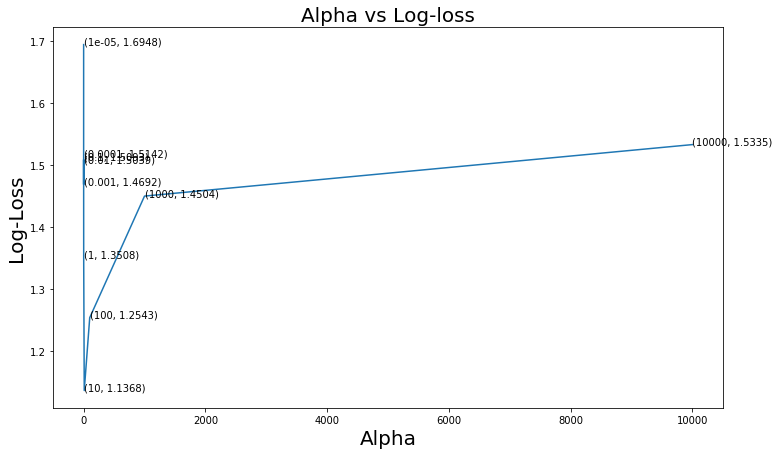

In [144]:
warnings.simplefilter('ignore')
alpha = [10**x for x in range(-5, 5)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(loss = "log", alpha = i, class_weight = "balanced")
    clf.fit(Train_X, Train_Y)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(Train_X, Train_Y)
    predicted_y = calib_clf.predict_proba(CV_X)
    cv_log_loss.append(log_loss(CV_Y, predicted_y, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CV_Y, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

<h2>Testing with best hyper-parameter</h2>

In [145]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(loss = "log", alpha = best_alpha, class_weight = "balanced")
clf.fit(Train_X, Train_Y)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(Train_X, Train_Y)

predict_train = calib_clf.predict_proba(Train_X)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(Train_Y, predict_train, labels=clf.classes_))

predict_cv = calib_clf.predict_proba(CV_X)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(CV_Y, predict_cv, labels=clf.classes_))

predict_test = calib_clf.predict_proba(Test_X)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(Test_Y, predict_test, labels=clf.classes_))

For values of best alpha =  10 the train log loss =: 0.6738349447177868
For values of best alpha =  10 the CV log loss =: 1.1314883600603884
For values of best alpha =  10 the test log loss =: 1.1014944605034171


In [146]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(calib_clf.predict(CV_X) - CV_Y)/CV_X.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(calib_clf.predict(Test_X) - Test_Y)/Test_X.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 40.49%
Percentage of mis-classified for Test points = 36.9%


In [48]:
table = table.append(pd.DataFrame([["Logistic Regresion(Balanced)", 0.6738, 1.1314, 1.101, "40.49%", "36.9%", "Good Fit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

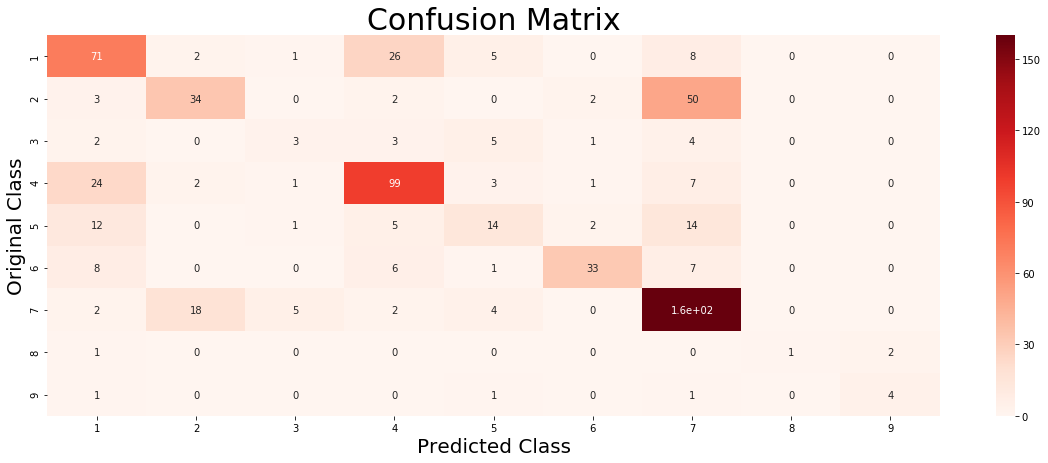

-----------------------------------------------------------------------------------------------------------------------------


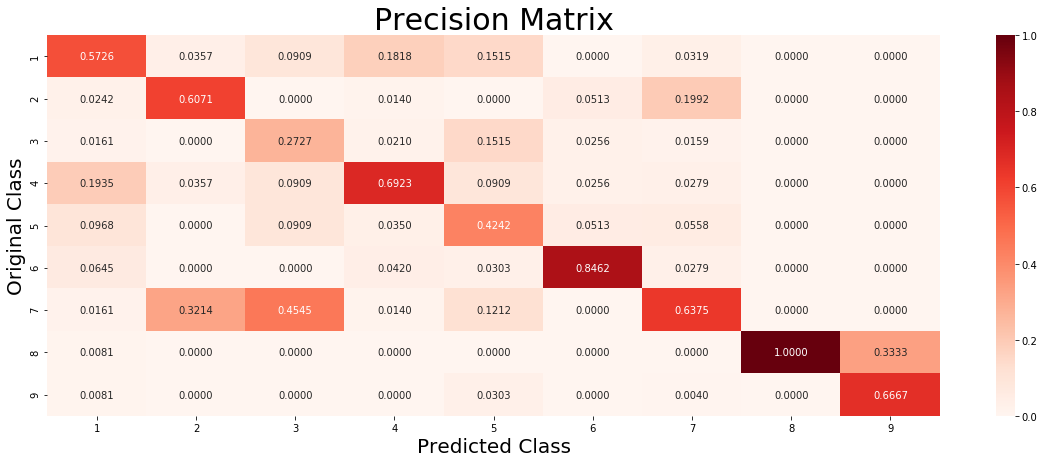

-----------------------------------------------------------------------------------------------------------------------------


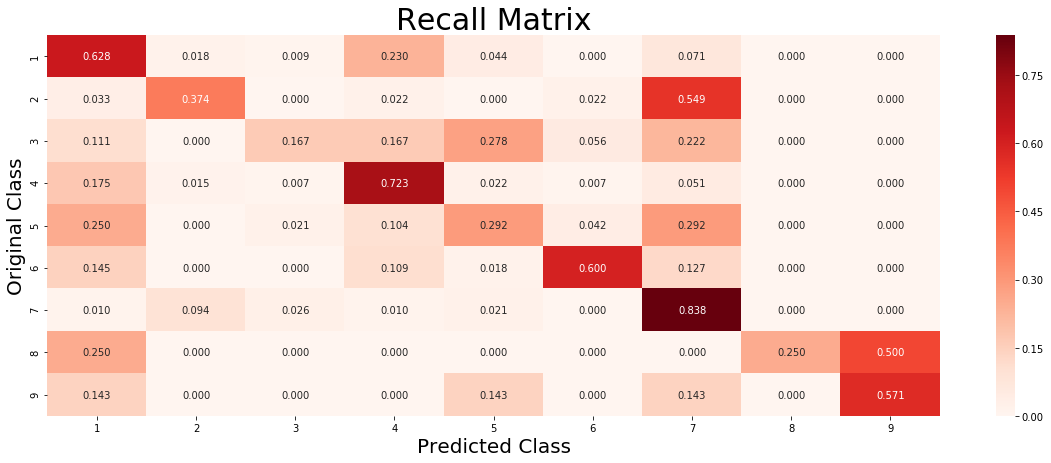

In [148]:
print_confusionMatrix(Test_Y, calib_clf.predict(Test_X))

<h2>Checking first 500 important features for correctly classified test point</h2>

In [151]:
testDataPoint = 5
no_feature = 500
predicted_cls = calib_clf.predict(Test_X[testDataPoint])
TrueLabel = Test_Y[testDataPoint]
predicted_prob = np.round(calib_clf.predict_proba(Test_X[testDataPoint]), 3)
print("Predicted Class label for test point = "+str(predicted_cls[0]))
print("Predicted Probabilities for test point = "+str(predicted_prob))
print("True class label for test point = "+str(TrueLabel))
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*63)
getImportantFeatures(indices[0], TestData.iloc[testDataPoint]["Gene"], TestData.iloc[testDataPoint]["Variation"], TestData.iloc[testDataPoint]["Text"], no_feature)

Predicted Class label for test point = 4
Predicted Probabilities for test point = [[0.025 0.014 0.003 0.922 0.015 0.007 0.013 0.001 0.001]]
True class label for test point = 4
---------------------------------------------------------------
1st Text feature [recently] is present in query point
2nd Text feature [potential] is present in query point
3rd Text feature [addition] is present in query point
4th Text feature [independent] is present in query point
5th Text feature [compared] is present in query point
6th Text feature [activation] is present in query point
7th Text feature [using] is present in query point
8th Text feature [suggests] is present in query point
9th Text feature [kinase] is present in query point
10th Text feature [presence] is present in query point
11th Text feature [shown] is present in query point
12th Text feature [10] is present in query point
13th Text feature [reported] is present in query point
14th Text feature [including] is present in query point
15th T

319th Text feature [induce] is present in query point
321st Text feature [appear] is present in query point
324th Text feature [described] is present in query point
325th Text feature [samples] is present in query point
326th Text feature [significant] is present in query point
332nd Text feature [example] is present in query point
333rd Text feature [targeted] is present in query point
338th Text feature [remains] is present in query point
342nd Text feature [fold] is present in query point
346th Text feature [coding] is present in query point
351st Text feature [identical] is present in query point
355th Text feature [2b] is present in query point
359th Text feature [established] is present in query point
360th Text feature [21] is present in query point
362nd Text feature [greater] is present in query point
363rd Text feature [27] is present in query point
372nd Text feature [3c] is present in query point
375th Text feature [position] is present in query point
380th Text feature [pa

<h2>Checking first 500 important features for incorrectly classified test point</h2>

In [153]:
testDataPoint = 10
no_feature = 500
predicted_cls = calib_clf.predict(Test_X[testDataPoint])
TrueLabel = Test_Y[testDataPoint]
predicted_prob = np.round(calib_clf.predict_proba(Test_X[testDataPoint]), 3)
print("Predicted Class label for test point = "+str(predicted_cls[0]))
print("Predicted Probabilities for test point = "+str(predicted_prob))
print("True class label for test point = "+str(TrueLabel))
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*63)
getImportantFeatures(indices[0], TestData.iloc[testDataPoint]["Gene"], TestData.iloc[testDataPoint]["Variation"], TestData.iloc[testDataPoint]["Text"], no_feature)

Predicted Class label for test point = 5
Predicted Probabilities for test point = [[0.074 0.007 0.005 0.117 0.719 0.073 0.002 0.002 0.   ]]
True class label for test point = 3
---------------------------------------------------------------
2nd Text feature [cells] is present in query point
4th Text feature [expression] is present in query point
7th Text feature [indicating] is present in query point
10th Text feature [presence] is present in query point
12th Text feature [10] is present in query point
14th Text feature [identified] is present in query point
15th Text feature [shown] is present in query point
18th Text feature [potential] is present in query point
21st Text feature [role] is present in query point
22nd Text feature [results] is present in query point
23rd Text feature [figure] is present in query point
24th Text feature [increased] is present in query point
27th Text feature [revealed] is present in query point
32nd Text feature [specific] is present in query point
33rd

406th Text feature [contrast] is present in query point
409th Text feature [suggested] is present in query point
416th Text feature [expected] is present in query point
417th Text feature [analyzed] is present in query point
419th Text feature [mouse] is present in query point
422nd Text feature [induced] is present in query point
424th Text feature [mechanisms] is present in query point
431st Text feature [work] is present in query point
437th Text feature [27] is present in query point
454th Text feature [growth] is present in query point
455th Text feature [introduction] is present in query point
458th Text feature [4b] is present in query point
462nd Text feature [leading] is present in query point
464th Text feature [lead] is present in query point
465th Text feature [reported] is present in query point
467th Text feature [downstream] is present in query point
469th Text feature [showing] is present in query point
470th Text feature [synthesis] is present in query point
472nd Text

## Logistic Regression without class balancing

### Hyper-Parameter Tuning

For alpha value of 1e-05 CV log loss = 1.6822267421428247
For alpha value of 0.0001 CV log loss = 1.4439792925818673
For alpha value of 0.001 CV log loss = 1.4693254245846028
For alpha value of 0.01 CV log loss = 1.42972062512733
For alpha value of 0.1 CV log loss = 1.4705901498451686
For alpha value of 1 CV log loss = 1.3617882483998252
For alpha value of 10 CV log loss = 1.1403742963873613
For alpha value of 100 CV log loss = 1.2347395370034169
For alpha value of 1000 CV log loss = 1.4121348341789688
For alpha value of 10000 CV log loss = 1.497412269848006


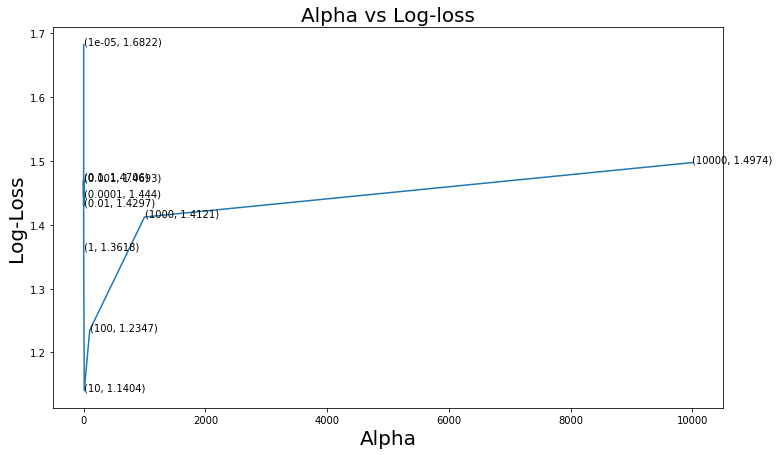

In [154]:
warnings.simplefilter('ignore')
alpha = [10**x for x in range(-5, 5)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(loss = "log", alpha = i)
    clf.fit(Train_X, Train_Y)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(Train_X, Train_Y)
    predicted_y = calib_clf.predict_proba(CV_X)
    cv_log_loss.append(log_loss(CV_Y, predicted_y, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CV_Y, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

<h2>Testing with best hyper-parameter</h2>

In [155]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(loss = "log", alpha = best_alpha)
clf.fit(Train_X, Train_Y)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(Train_X, Train_Y)

predict_train = calib_clf.predict_proba(Train_X)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(Train_Y, predict_train, labels=clf.classes_))

predict_cv = calib_clf.predict_proba(CV_X)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(CV_Y, predict_cv, labels=clf.classes_))

predict_test = calib_clf.predict_proba(Test_X)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(Test_Y, predict_test, labels=clf.classes_))

For values of best alpha =  10 the train log loss =: 0.6640724039427359
For values of best alpha =  10 the CV log loss =: 1.1335247800136392
For values of best alpha =  10 the test log loss =: 1.0956791338522687


In [156]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(calib_clf.predict(CV_X) - CV_Y)/CV_X.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(calib_clf.predict(Test_X) - Test_Y)/Test_X.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 39.36%
Percentage of mis-classified for Test points = 37.5%


In [49]:
table = table.append(pd.DataFrame([["Logistic Regresion(Imbalanced)", 0.6640, 1.1335, 1.0956, "39.36%", "37.5%", "Good Fit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

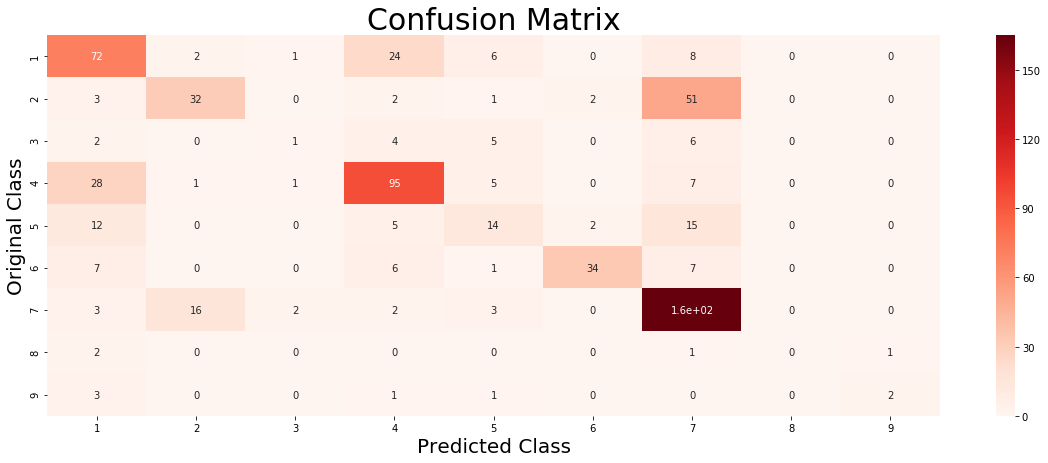

-----------------------------------------------------------------------------------------------------------------------------


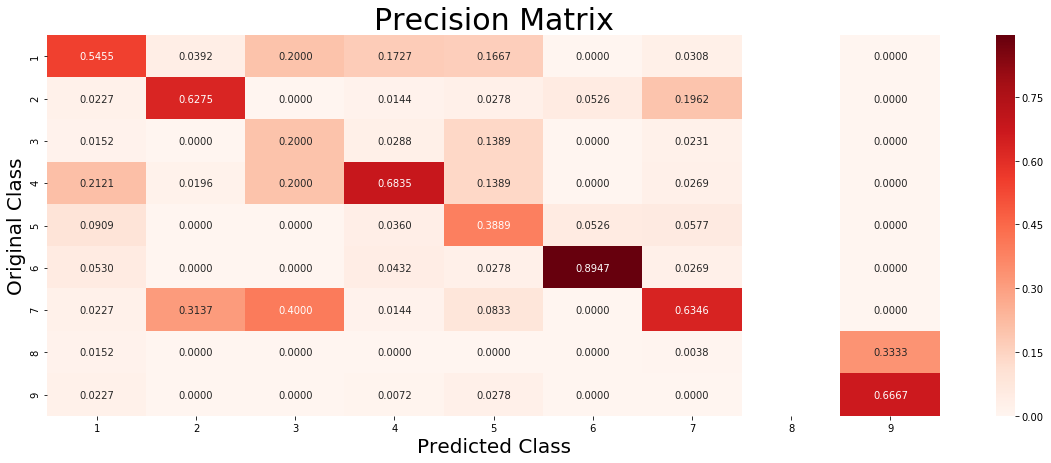

-----------------------------------------------------------------------------------------------------------------------------


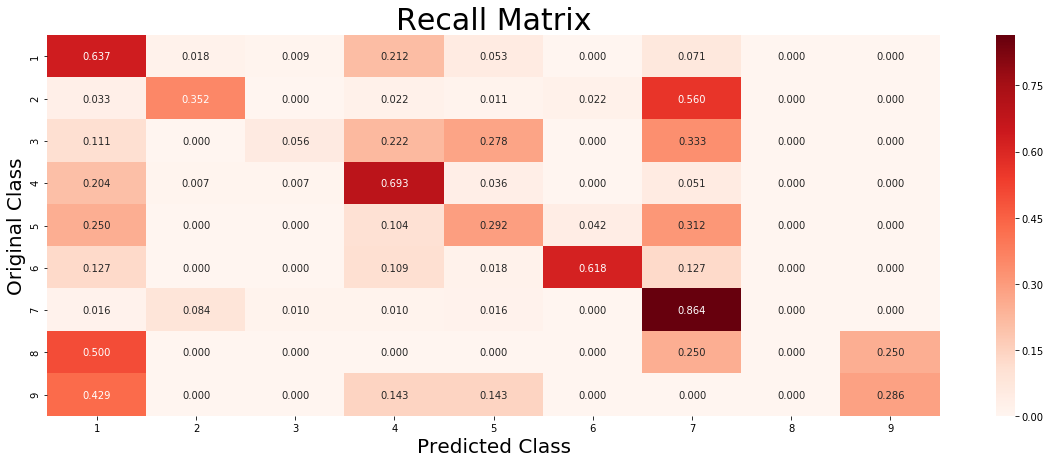

In [158]:
print_confusionMatrix(Test_Y, calib_clf.predict(Test_X))

<h2>Checking first 500 important features for correctly classified test point</h2>

In [160]:
testDataPoint = 5
no_feature = 500
predicted_cls = calib_clf.predict(Test_X[testDataPoint])
TrueLabel = Test_Y[testDataPoint]
predicted_prob = np.round(calib_clf.predict_proba(Test_X[testDataPoint]), 3)
print("Predicted Class label for test point = "+str(predicted_cls[0]))
print("Predicted Probabilities for test point = "+str(predicted_prob))
print("True class label for test point = "+str(TrueLabel))
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*63)
getImportantFeatures(indices[0], TestData.iloc[testDataPoint]["Gene"], TestData.iloc[testDataPoint]["Variation"], TestData.iloc[testDataPoint]["Text"], no_feature)

Predicted Class label for test point = 4
Predicted Probabilities for test point = [[0.028 0.014 0.002 0.922 0.01  0.007 0.014 0.002 0.   ]]
True class label for test point = 4
---------------------------------------------------------------
1st Text feature [recently] is present in query point
3rd Text feature [potential] is present in query point
7th Text feature [activation] is present in query point
8th Text feature [independent] is present in query point
9th Text feature [addition] is present in query point
13th Text feature [compared] is present in query point
14th Text feature [currently] is present in query point
15th Text feature [kinase] is present in query point
17th Text feature [suggests] is present in query point
20th Text feature [concentrations] is present in query point
25th Text feature [screening] is present in query point
30th Text feature [activating] is present in query point
36th Text feature [identification] is present in query point
41st Text feature [using] is p

<h2>Checking first 500 important features for incorrectly classified test point</h2>

In [161]:
testDataPoint = 25
no_feature = 500
predicted_cls = calib_clf.predict(Test_X[testDataPoint])
TrueLabel = Test_Y[testDataPoint]
predicted_prob = np.round(calib_clf.predict_proba(Test_X[testDataPoint]), 4)
print("Predicted Class label for test point = "+str(predicted_cls[0]))
print("Predicted Probabilities for test point = "+str(predicted_prob))
print("True class label for test point = "+str(TrueLabel))
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*63)
getImportantFeatures(indices[0], TestData.iloc[testDataPoint]["Gene"], TestData.iloc[testDataPoint]["Variation"], TestData.iloc[testDataPoint]["Text"], no_feature)

Predicted Class label for test point = 1
Predicted Probabilities for test point = [[0.5426 0.0067 0.0012 0.1688 0.2183 0.0566 0.0032 0.0025 0.    ]]
True class label for test point = 5
---------------------------------------------------------------
1st Text feature [kinase] is present in query point
3rd Text feature [contrast] is present in query point
8th Text feature [shown] is present in query point
16th Text feature [previously] is present in query point
20th Text feature [described] is present in query point
26th Text feature [activation] is present in query point
33rd Text feature [activity] is present in query point
39th Text feature [constitutive] is present in query point
43rd Text feature [mutations] is present in query point
45th Text feature [positive] is present in query point
47th Text feature [expressed] is present in query point
51st Text feature [cells] is present in query point
52nd Text feature [downstream] is present in query point
61st Text feature [phosphorylation

## Linear SVM

### Hyper-Parameter Tuning

For alpha value of 1e-05 CV log loss = 1.6525311487762264
For alpha value of 0.0001 CV log loss = 1.508312724941579
For alpha value of 0.001 CV log loss = 1.5148386727259073
For alpha value of 0.01 CV log loss = 1.492017021066627
For alpha value of 0.1 CV log loss = 1.5003191875232478
For alpha value of 1 CV log loss = 1.4476661721062734
For alpha value of 10 CV log loss = 1.2486288231044749
For alpha value of 100 CV log loss = 1.3031323911685826
For alpha value of 1000 CV log loss = 1.4723578568504232
For alpha value of 10000 CV log loss = 1.547033276044576


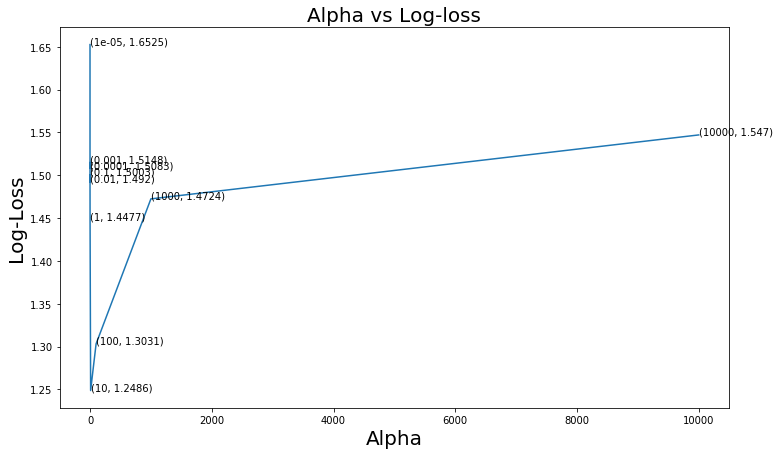

In [162]:
alpha = [10**x for x in range(-5, 5)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(loss = "hinge", alpha = i, class_weight = "balanced")
    clf.fit(Train_X, Train_Y)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(Train_X, Train_Y)
    predicted_y = calib_clf.predict_proba(CV_X)
    cv_log_loss.append(log_loss(CV_Y, predicted_y, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(CV_Y, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

<h2>Testing with best best Hyper-Parameter</h2>

In [163]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(loss = "hinge", alpha = best_alpha, class_weight = "balanced")
clf.fit(Train_X, Train_Y)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(Train_X, Train_Y)

predict_train = calib_clf.predict_proba(Train_X)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(Train_Y, predict_train, labels=clf.classes_))

predict_cv = calib_clf.predict_proba(CV_X)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(CV_Y, predict_cv, labels=clf.classes_))

predict_test = calib_clf.predict_proba(Test_X)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(Test_Y, predict_test, labels=clf.classes_))

For values of best alpha =  10 the train log loss =: 0.8022730656225745
For values of best alpha =  10 the CV log loss =: 1.2399335397940394
For values of best alpha =  10 the test log loss =: 1.221772926915284


In [164]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(calib_clf.predict(CV_X) - CV_Y)/CV_X.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(calib_clf.predict(Test_X) - Test_Y)/Test_X.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 39.36%
Percentage of mis-classified for Test points = 38.7%


In [50]:
table = table.append(pd.DataFrame([["Linear SVM(Balanced)", 0.8022, 1.2399, 1.2217, "39.36%", "38.7%", "Good Fit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

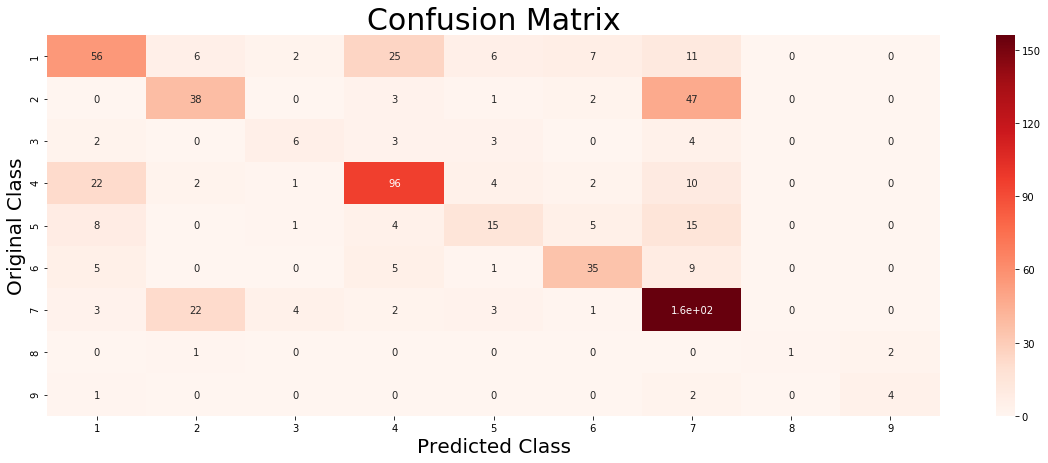

-----------------------------------------------------------------------------------------------------------------------------


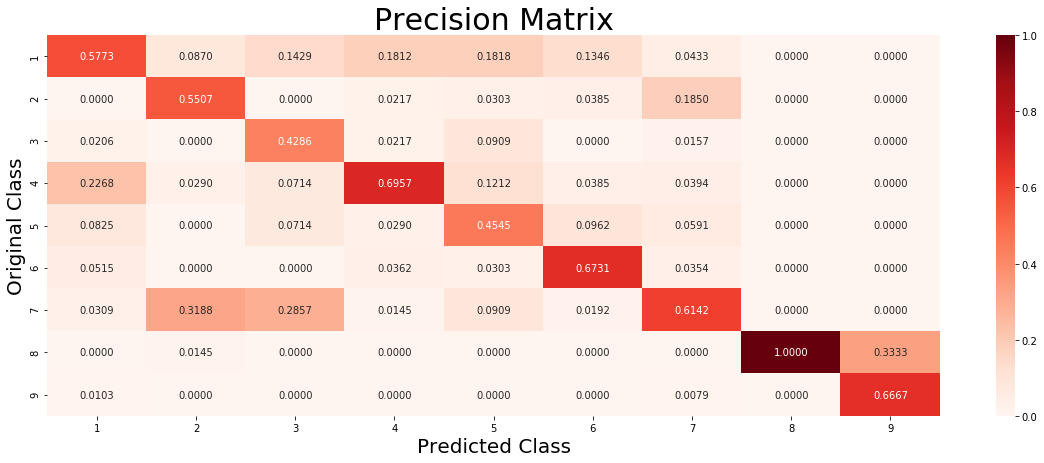

-----------------------------------------------------------------------------------------------------------------------------


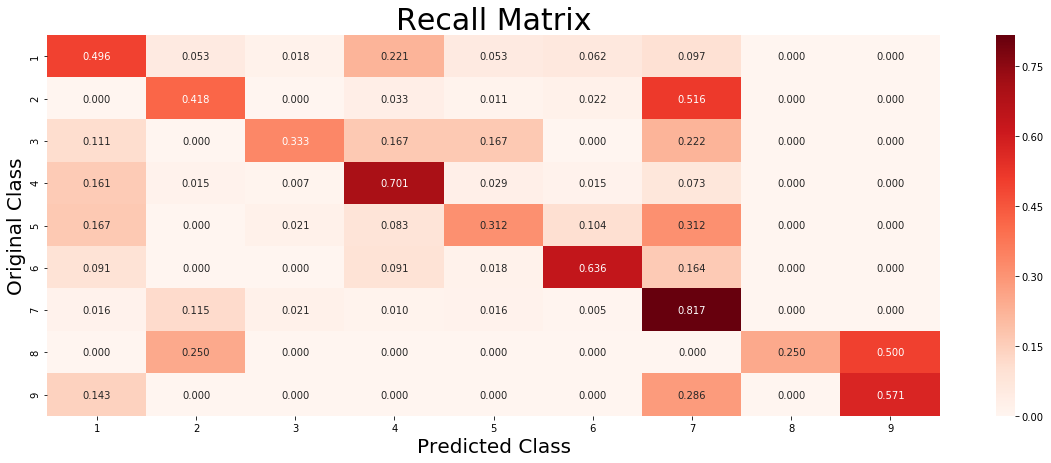

In [166]:
print_confusionMatrix(Test_Y, calib_clf.predict(Test_X))

<h2>Checking first 500 important features for correctly classified test point</h2>

In [167]:
testDataPoint = 5
no_feature = 500
predicted_cls = calib_clf.predict(Test_X[testDataPoint])
TrueLabel = Test_Y[testDataPoint]
predicted_prob = np.round(calib_clf.predict_proba(Test_X[testDataPoint]), 4)
print("Predicted Class label for test point = "+str(predicted_cls[0]))
print("Predicted Probabilities for test point = "+str(predicted_prob))
print("True class label for test point = "+str(TrueLabel))
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*63)
getImportantFeatures(indices[0], TestData.iloc[testDataPoint]["Gene"], TestData.iloc[testDataPoint]["Variation"], TestData.iloc[testDataPoint]["Text"], no_feature)

Predicted Class label for test point = 4
Predicted Probabilities for test point = [[0.0467 0.062  0.0062 0.7801 0.0256 0.0236 0.0494 0.0042 0.0022]]
True class label for test point = 4
---------------------------------------------------------------
10th Text feature [recently] is present in query point
71st Text feature [suggests] is present in query point
78th Text feature [activation] is present in query point
86th Text feature [potential] is present in query point
141st Text feature [screening] is present in query point
180th Text feature [sequences] is present in query point
199th Text feature [concentrations] is present in query point
202nd Text feature [fused] is present in query point
222nd Text feature [addition] is present in query point
243rd Text feature [independent] is present in query point
291st Text feature [identification] is present in query point
297th Text feature [mainly] is present in query point
392nd Text feature [confirmed] is present in query point
453rd Text 

<h2>Checking first 500 important features for incorrectly classified test point</h2>

In [168]:
testDataPoint = 25
no_feature = 500
predicted_cls = calib_clf.predict(Test_X[testDataPoint])
TrueLabel = Test_Y[testDataPoint]
predicted_prob = np.round(calib_clf.predict_proba(Test_X[testDataPoint]), 4)
print("Predicted Class label for test point = "+str(predicted_cls[0]))
print("Predicted Probabilities for test point = "+str(predicted_prob))
print("True class label for test point = "+str(TrueLabel))
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*63)
getImportantFeatures(indices[0], TestData.iloc[testDataPoint]["Gene"], TestData.iloc[testDataPoint]["Variation"], TestData.iloc[testDataPoint]["Text"], no_feature)

Predicted Class label for test point = 1
Predicted Probabilities for test point = [[0.3271 0.0315 0.0042 0.2252 0.3249 0.037  0.0352 0.0099 0.005 ]]
True class label for test point = 5
---------------------------------------------------------------
76th Text feature [contrast] is present in query point
112nd Text feature [shown] is present in query point
119th Text feature [kinase] is present in query point
222nd Text feature [psi] is present in query point
225th Text feature [previously] is present in query point
236th Text feature [explain] is present in query point
248th Text feature [activity] is present in query point
261st Text feature [iii] is present in query point
269th Text feature [right] is present in query point
275th Text feature [immobilized] is present in query point
312nd Text feature [positive] is present in query point
323rd Text feature [levels] is present in query point
350th Text feature [discussion] is present in query point
376th Text feature [fused] is present 

## Random Forest

### Hyper-Parameter Tuning

In [88]:
base_learners = [100, 200, 500, 1000]
max_depth_baseLearners = [7, 12]
cv_log_loss = []

for i in base_learners:
    for j in max_depth_baseLearners:
        clf = RandomForestClassifier(n_estimators = i, max_depth = j, n_jobs = -1)
        clf.fit(Train_X, Train_Y)
        calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
        calib_clf.fit(Train_X, Train_Y)
        predicted_y = calib_clf.predict_proba(CV_X)
        cv_log_loss.append(log_loss(CV_Y, predicted_y, labels=clf.classes_))
        print("For Number of base learners "+str(i)+" and max depth of a tree "+str(j)+" CV log loss = "+str(log_loss(CV_Y, predicted_y, labels=clf.classes_)))

For Number of base learners 100 and max depth of a tree 7 CV log loss = 1.154436650893394
For Number of base learners 100 and max depth of a tree 12 CV log loss = 1.1000600923075554
For Number of base learners 200 and max depth of a tree 7 CV log loss = 1.155345537255194
For Number of base learners 200 and max depth of a tree 12 CV log loss = 1.1026486586391353
For Number of base learners 500 and max depth of a tree 7 CV log loss = 1.151956419270043
For Number of base learners 500 and max depth of a tree 12 CV log loss = 1.0912942995856048
For Number of base learners 1000 and max depth of a tree 7 CV log loss = 1.1442461540133317
For Number of base learners 1000 and max depth of a tree 12 CV log loss = 1.089753734225643


In [93]:
gridLogLoss = []
subLogLoss = []
x = [x for x in range(1, 8, 2)]
for i in range(8):
    subLogLoss.append(np.round(cv_log_loss[i], 4))
    if i in x:
        gridLogLoss.append(subLogLoss)
        subLogLoss = []

In [94]:
gridLogLossFrame = pd.DataFrame(gridLogLoss, columns = max_depth_baseLearners)
gridLogLossFrame["Base_Learners"] = base_learners
gridLogLossFrame.set_index("Base_Learners", append = False, drop = True, inplace = True)

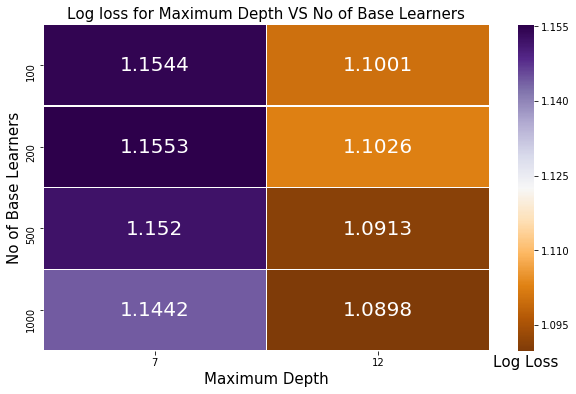

In [95]:
plt.figure(figsize = (10,6))
plt.title("Log loss for Maximum Depth VS No of Base Learners", size = 15)
ax = sns.heatmap(gridLogLossFrame, annot = True, cmap="PuOr", linewidths = 0.5, fmt = ".5g", annot_kws={"size": 20})
ax.figure.axes[0].set_xlabel("Maximum Depth", size = 15)
ax.figure.axes[0].set_ylabel("No of Base Learners", size = 15)
ax.figure.axes[-1].set_xlabel("Log Loss", size = 15)
plt.show()

<h2>Testing with best Hyper Parameter</h2>

In [97]:
best = np.argmin(cv_log_loss)
best_estimator = base_learners[int(best/2)]
best_depth = max_depth_baseLearners[int(best/4)]
clf = RandomForestClassifier(n_estimators = best_estimator, max_depth = best_depth, n_jobs = -1)
clf.fit(Train_X, Train_Y)
calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf.fit(Train_X, Train_Y)

predict_train = calib_clf.predict_proba(Train_X)
print("For Number of base learners "+str(best_estimator)+" and max depth of a tree "+str(best_depth)+" Train log loss = "+str(log_loss(Train_Y, predict_train, labels=clf.classes_)))

predict_cv = calib_clf.predict_proba(CV_X)
print("For Number of base learners "+str(best_estimator)+" and max depth of a tree "+str(best_depth)+" CV log loss = "+str(log_loss(CV_Y, predict_cv, labels=clf.classes_)))

predict_test = calib_clf.predict_proba(Test_X)
print("For Number of base learners "+str(best_estimator)+" and max depth of a tree "+str(best_depth)+" Test log loss = "+str(log_loss(Test_Y, predict_test, labels=clf.classes_)))

For Number of base learners 1000 and max depth of a tree 12 Train log loss = 0.6165995922410343
For Number of base learners 1000 and max depth of a tree 12 CV log loss = 1.0961313160427155
For Number of base learners 1000 and max depth of a tree 12 Test log loss = 1.0994898571114247


In [98]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(calib_clf.predict(CV_X) - CV_Y)/CV_X.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(calib_clf.predict(Test_X) - Test_Y)/Test_X.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 38.23%
Percentage of mis-classified for Test points = 35.69%


In [51]:
table = table.append(pd.DataFrame([["Random Forest", 0.6165, 1.0961, 1.0994, "38.23%", "35.69%", "Best Fit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

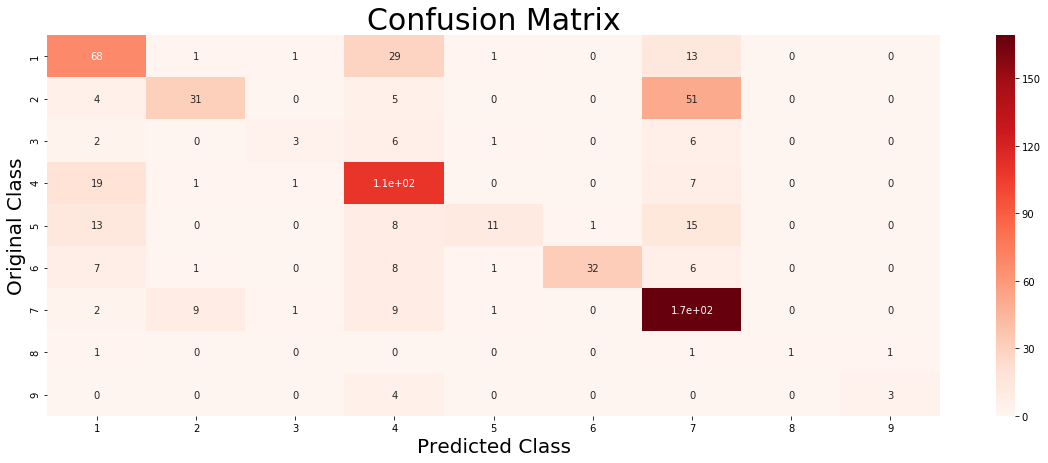

-----------------------------------------------------------------------------------------------------------------------------


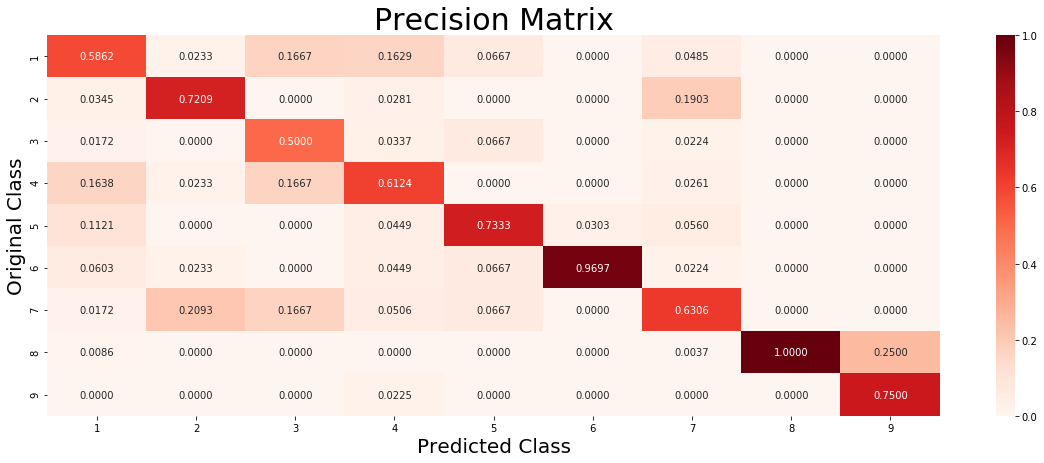

-----------------------------------------------------------------------------------------------------------------------------


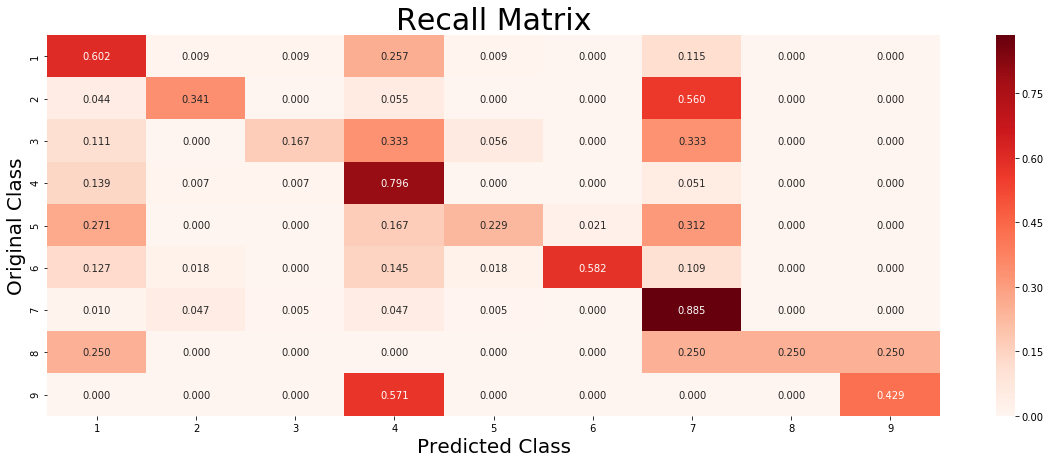

In [99]:
print_confusionMatrix(Test_Y, calib_clf.predict(Test_X))

<h2>Checking first 100 important features for correctly classified test point</h2>

In [116]:
testDataPoint = 5
no_feature = 100
predicted_cls = calib_clf.predict(Test_X[testDataPoint])
TrueLabel = Test_Y[testDataPoint]
predicted_prob = np.round(calib_clf.predict_proba(Test_X[testDataPoint]), 4)
print("Predicted Class label for test point = "+str(predicted_cls[0]))
print("Predicted Probabilities for test point = "+str(predicted_prob))
print("True class label for test point = "+str(TrueLabel))
indices = np.argsort(-clf.feature_importances_)
print("-"*63)
getImportantFeatures(indices[:no_feature], TestData.iloc[testDataPoint]["Gene"], TestData.iloc[testDataPoint]["Variation"], TestData.iloc[testDataPoint]["Text"], no_feature)

Predicted Class label for test point = 4
Predicted Probabilities for test point = [[0.0687 0.0322 0.0129 0.779  0.0342 0.0307 0.0345 0.0037 0.0042]]
True class label for test point = 4
---------------------------------------------------------------
1st Text feature [kinase] is present in query point
3rd Text feature [activated] is present in query point
4th Text feature [activation] is present in query point
6th Text feature [activating] is present in query point
7th Text feature [inhibitors] is present in query point
10th Text feature [phosphorylation] is present in query point
11th Text feature [inhibitor] is present in query point
12th Text feature [suppressor] is present in query point
16th Text feature [function] is present in query point
17th Text feature [nonsense] is present in query point
24th Text feature [growth] is present in query point
25th Text feature [pathogenic] is present in query point
26th Text feature [oncogenic] is present in query point
28th Text feature [therap

<h2>Checking first 100 important features for incorrectly classified test point</h2>

In [115]:
testDataPoint = 25
no_feature = 100
predicted_cls = calib_clf.predict(Test_X[testDataPoint])
TrueLabel = Test_Y[testDataPoint]
predicted_prob = np.round(calib_clf.predict_proba(Test_X[testDataPoint]), 4)
print("Predicted Class label for test point = "+str(predicted_cls[0]))
print("Predicted Probabilities for test point = "+str(predicted_prob))
print("True class label for test point = "+str(TrueLabel))
indices = np.argsort(-clf.feature_importances_)
print("-"*63)
getImportantFeatures(indices[:no_feature], TestData.iloc[testDataPoint]["Gene"], TestData.iloc[testDataPoint]["Variation"], TestData.iloc[testDataPoint]["Text"], no_feature)

Predicted Class label for test point = 1
Predicted Probabilities for test point = [[0.6004 0.0173 0.0106 0.045  0.2803 0.0293 0.0116 0.0025 0.0029]]
True class label for test point = 5
---------------------------------------------------------------
1st Text feature [kinase] is present in query point
4th Text feature [activation] is present in query point
6th Text feature [activating] is present in query point
10th Text feature [phosphorylation] is present in query point
12th Text feature [suppressor] is present in query point
16th Text feature [function] is present in query point
19th Text feature [signaling] is present in query point
20th Text feature [constitutive] is present in query point
23rd Text feature [downstream] is present in query point
25th Text feature [pathogenic] is present in query point
27th Text feature [activate] is present in query point
33rd Text feature [cells] is present in query point
39th Text feature [protein] is present in query point
41st Text feature [dele

## Stacking the Models

### Stacking 4 best performing Models with their best hyper-parameters: Naive Bayes, Logistic Regression, Linear SVM, Random Forest

In [175]:
clf_NB = MultinomialNB(alpha=10**-5)
clf_NB.fit(Train_X, Train_Y)
calib_clf_NB = CalibratedClassifierCV(clf_NB, method = "sigmoid")
calib_clf_NB.fit(Train_X, Train_Y)
print("Naive Bayes CV Log Loss: "+str(np.round(log_loss(CV_Y, calib_clf_NB.predict_proba(CV_X), labels=clf_NB.classes_), 4)))

clf_LR = SGDClassifier(loss = "log", alpha = 10, class_weight = "balanced")
clf_LR.fit(Train_X, Train_Y)
calib_clf_LR = CalibratedClassifierCV(clf_LR, method = "sigmoid")
calib_clf_LR.fit(Train_X, Train_Y)
print("Logistic Regression CV Log Loss: "+str(np.round(log_loss(CV_Y, calib_clf_LR.predict_proba(CV_X), labels=clf_LR.classes_), 4)))

clf_SVM = SGDClassifier(loss = "hinge", alpha = 10, class_weight = "balanced")
clf_SVM.fit(Train_X, Train_Y)
calib_clf_SVM = CalibratedClassifierCV(clf_SVM, method = "sigmoid")
calib_clf_SVM.fit(Train_X, Train_Y)
print("SVM CV Log Loss: "+str(np.round(log_loss(CV_Y, calib_clf_SVM.predict_proba(CV_X), labels=clf_SVM.classes_), 4)))

clf_RF = RandomForestClassifier(n_estimators = 1000, max_depth = 12, n_jobs = -1)
clf_RF.fit(Train_X, Train_Y)
calib_clf_RF = CalibratedClassifierCV(clf_RF, method = "sigmoid")
calib_clf_RF.fit(Train_X, Train_Y)
print("Random Forest CV Log Loss: "+str(np.round(log_loss(CV_Y, calib_clf_RF.predict_proba(CV_X), labels=clf_RF.classes_), 4)))

Naive Bayes CV Log Loss: 1.3472
Logistic Regression CV Log Loss: 1.1333
SVM CV Log Loss: 1.2505
Random Forest CV Log Loss: 1.093


In [181]:
cv_log_loss = []
alpha = [10**x for x in range(-3, 0)]
for i in alpha:
    lr = SGDClassifier(loss = "log", alpha = i)
    stack_clf = StackingClassifier(classifiers=[calib_clf_NB, calib_clf_LR, calib_clf_SVM, calib_clf_RF], meta_classifier=lr, use_probas=True)
    stack_clf.fit(Train_X, Train_Y)
    cv_log_loss.append(log_loss(CV_Y, stack_clf.predict_proba(CV_X)))
    print("Stacking Classifer : For alpha value: "+str(i)+" Log Loss: "+str(np.round(log_loss(CV_Y, stack_clf.predict_proba(CV_X)), 4)))

Stacking Classifer : For alpha value: 0.001 Log Loss: 1.139
Stacking Classifer : For alpha value: 0.01 Log Loss: 1.1807
Stacking Classifer : For alpha value: 0.1 Log Loss: 1.5125


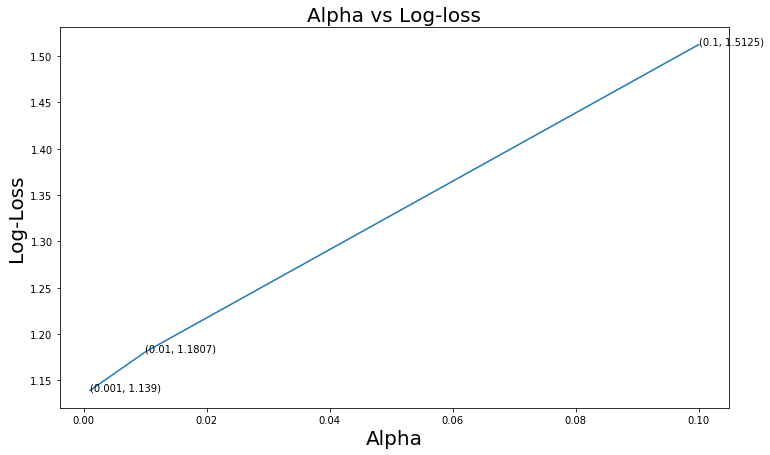

In [182]:
plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

In [184]:
best_alpha = alpha[np.argmin(cv_log_loss)]

lr = SGDClassifier(loss = "log", alpha = best_alpha)
stack_clf = StackingClassifier(classifiers=[calib_clf_NB, calib_clf_LR, calib_clf_SVM, calib_clf_RF], meta_classifier=lr, use_probas=True)
stack_clf.fit(Train_X, Train_Y)

trainLogLoss = log_loss(Train_Y, stack_clf.predict_proba(Train_X))
print("Train Log Loss on Stacking Classifier =  "+str(np.round(trainLogLoss, 4)))

cvLogLoss = log_loss(CV_Y, stack_clf.predict_proba(CV_X))
print("Cross Validation Log Loss on Stacking Classifier =  "+str(np.round(cvLogLoss, 4)))

testLogLoss = log_loss(Test_Y, stack_clf.predict_proba(Test_X))
print("Test Log Loss on Stacking Classifier =  "+str(np.round(testLogLoss, 4)))

print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(stack_clf.predict(CV_X) - CV_Y)/CV_X.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(stack_clf.predict(Test_X) - Test_Y)/Test_X.shape[0]*100), 2))+"%")

Train Log Loss on Stacking Classifier =  0.378
Cross Validation Log Loss on Stacking Classifier =  1.1311
Test Log Loss on Stacking Classifier =  1.0578
Percentage of mis-classified for CV points = 38.98%
Percentage of mis-classified for Test points = 35.09%


In [52]:
table = table.append(pd.DataFrame([["Stacking Classifier", 0.378, 1.1311, 1.0578, "38.98%", "35.09%", "Best Fit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

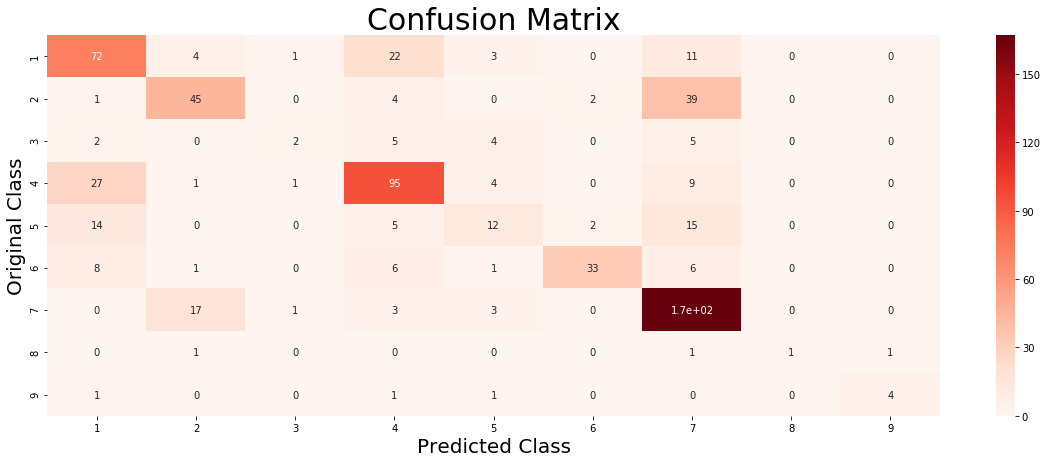

-----------------------------------------------------------------------------------------------------------------------------


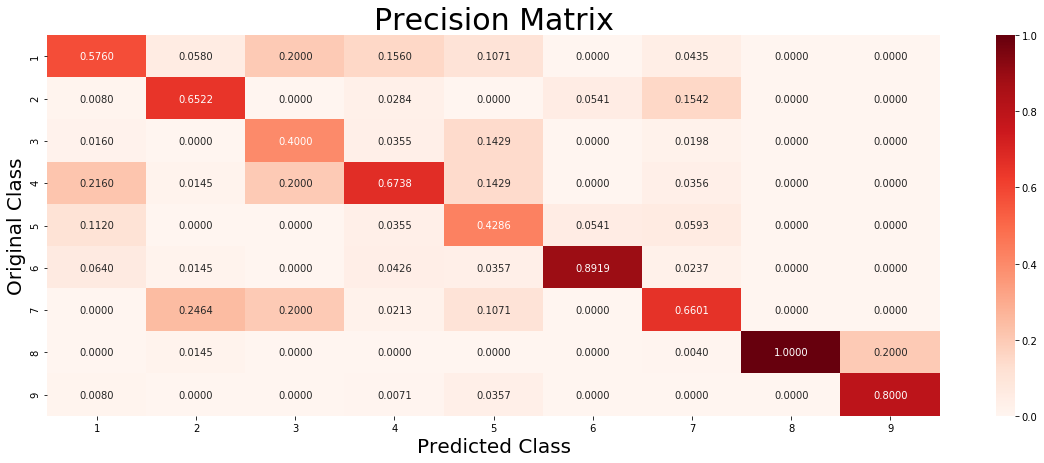

-----------------------------------------------------------------------------------------------------------------------------


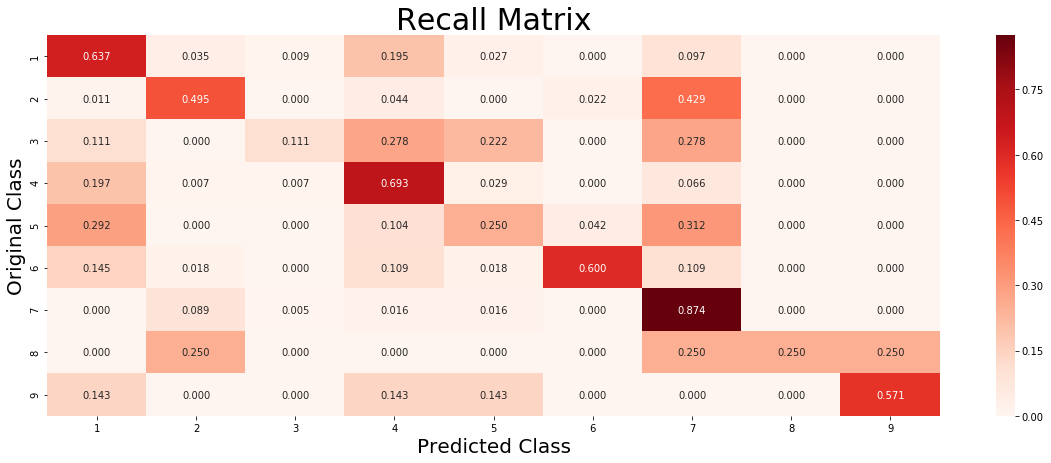

In [186]:
print_confusionMatrix(Test_Y, stack_clf.predict(Test_X))

## Maximum Voting Classifier: Logistic Regression, Linear SVM, Random Forest

Log loss (train) on the VotingClassifier :0.68
Log loss (CV) on the VotingClassifier :1.13
Log loss (test) on the VotingClassifier :1.11
Percentage of mis-classified for cv points :39.55%
Percentage of mis-classified for Test points :35.84%


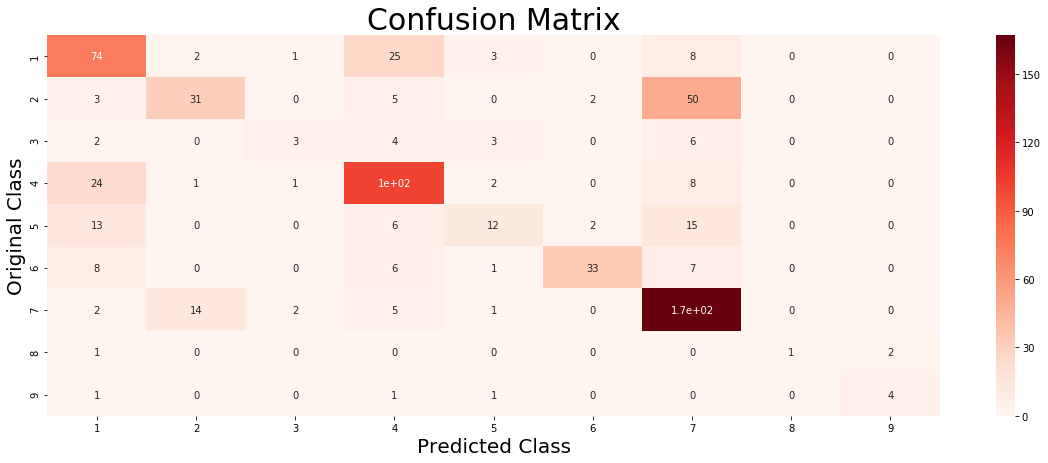

-----------------------------------------------------------------------------------------------------------------------------


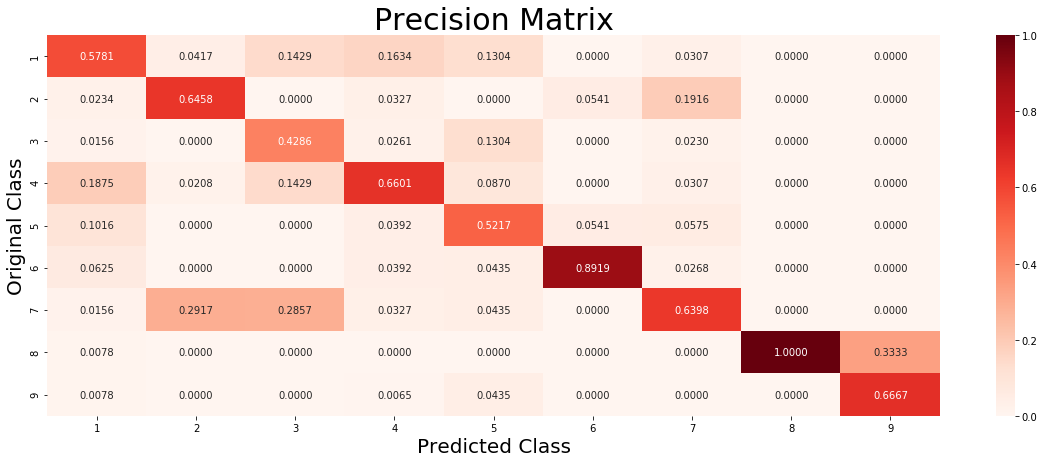

-----------------------------------------------------------------------------------------------------------------------------


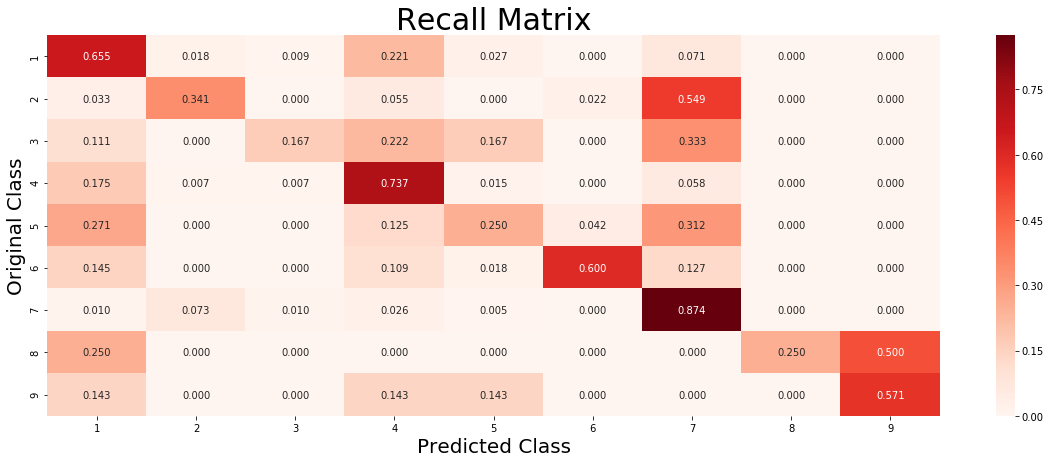

In [191]:
vclf = VotingClassifier(estimators=[('lr', calib_clf_LR), ('svc', calib_clf_SVM), ('rf', calib_clf_RF)], voting='soft', n_jobs = -1)
vclf.fit(Train_X, Train_Y)
print("Log loss (train) on the VotingClassifier :"+str(np.round(log_loss(Train_Y, vclf.predict_proba(Train_X), labels=vclf.classes_), 2)))
print("Log loss (CV) on the VotingClassifier :"+str(np.round(log_loss(CV_Y, vclf.predict_proba(CV_X), labels=vclf.classes_), 2)))
print("Log loss (test) on the VotingClassifier :"+str(np.round(log_loss(Test_Y, vclf.predict_proba(Test_X), labels=vclf.classes_), 2)))
print("Percentage of mis-classified for cv points :"+str(np.round((np.count_nonzero(vclf.predict(CV_X) - CV_Y)/CV_X.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points :"+str(np.round((np.count_nonzero(vclf.predict(Test_X) - Test_Y)/Test_X.shape[0]*100), 2))+"%")
print_confusionMatrix(Test_Y, vclf.predict(Test_X))

In [53]:
table = table.append(pd.DataFrame([["Maximum Voting Classifier", 0.68, 1.13, 1.11, "39.55%", "35.84%", "Best Fit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))
table.reset_index(drop = True, inplace = True)

## Summary

In [54]:
table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Remarks
0,Naive Bayes,0.9031,1.3471,1.2976,42.75%,39.46%,GoodFit
1,KNN,0.0952,1.4864,1.5290,45.39%,44.88%,OverFit
2,Logistic Regresion(Balanced),0.6738,1.1314,1.1010,40.49%,36.9%,Good Fit
3,Logistic Regresion(Imbalanced),0.6640,1.1335,1.0956,39.36%,37.5%,Good Fit
4,Linear SVM(Balanced),0.8022,1.2399,1.2217,39.36%,38.7%,Good Fit
5,Random Forest,0.6165,1.0961,1.0994,38.23%,35.69%,Best Fit
6,Stacking Classifier,0.3780,1.1311,1.0578,38.98%,35.09%,Best Fit
7,Maximum Voting Classifier,0.6800,1.1300,1.1100,39.55%,35.84%,Best Fit


In [55]:
table2 = table.drop(["Mis-Classified CV", "Mis-Classified Test", "Remarks"], axis = 1)

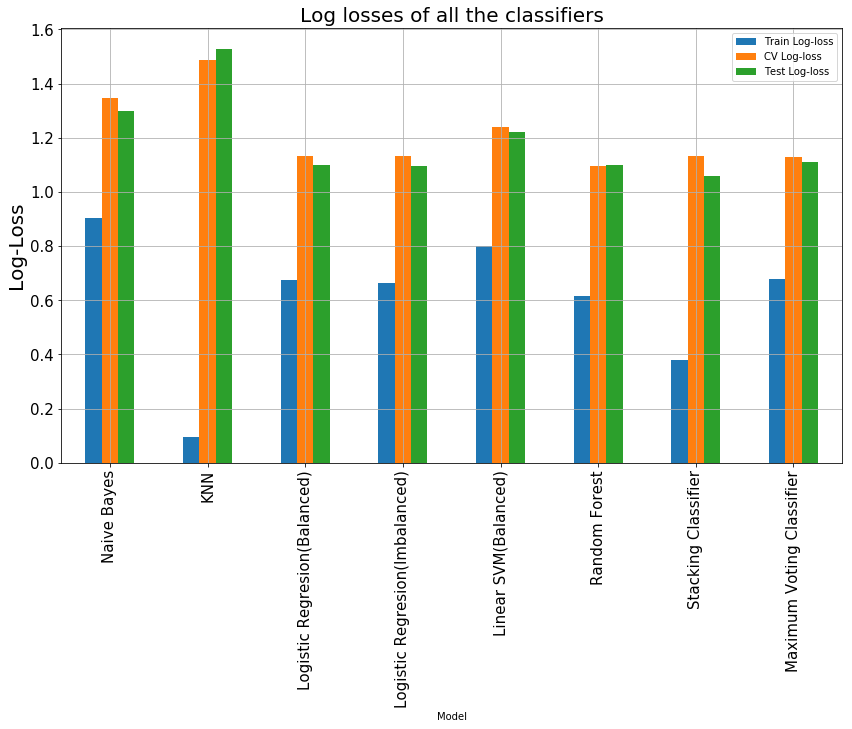

In [73]:
table2.plot(x = "Model", kind = "bar", figsize = (14, 8), grid = True, fontsize = 15)
plt.title("Log losses of all the classifiers", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

<h1>So, far our best model is Stacking Classifer with test log loss of 1.0578</h1>